# Install

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lightgbm --quiet

In [ ]:
!pip install xgboost --quiet

In [ ]:
!pip install shap --quiet

In [ ]:
!pip install optuna --quiet

In [ ]:
!pip install mlflow --quiet

In [ ]:
!pip install pyngrok --quiet

# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [ ]:
import warnings
warnings.simplefilter(action='ignore')

In [ ]:
import seaborn as sns

# Optional import

In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/data')
from boruta import BorutaPy

In [ ]:
import xgboost as xg

In [ ]:
from shap import TreeExplainer
import shap

In [ ]:
import mlflow
import mlflow.lightgbm
mlflow.set_tracking_uri("/content/drive/MyDrive/MLFLOW")

In [ ]:
import optuna

# Load data

In [ ]:
np.random.seed(42)
test_path = '/content/drive/MyDrive/data/predict6.parquet'
data_path = '/content/drive/MyDrive/data/train6.parquet'
data = pd.read_parquet(data_path) 
data = data[data.sub_cat != 25]
data = data[data.shop_id != 9]
print(len(data))
data.columns

18300030


Index(['item_id', 'shop_id', 'item_cnt_month', 'date_block_num', 'city', 'cat',
       'sub_cat', 'lag_item_shop1', 'lag_item_shop2', 'lag_item_shop3',
       'rol_avg_item2', 'rol_max_item4', 'rol_avg_item6', 'rol_std_item6',
       'rol_sum_sub_cat2', 'rol_avg_sub_cat4', 'rol_std_sub_cat4',
       'rol_avg_sub_cat6', 'rol_median_item4', 'rol_avg_cat6', 'rol_sum_cat2',
       'rol_std_cat4', 'rol_avg_shop2', 'rol_avg_shop4', 'rol_median_shop6',
       'rol_avg_item_shop2', 'rol_avg_item_shop4', 'rol_avg_item_shop6',
       'rol_min_shop5', 'rol_sum_cat1', 'rol_sum_sub_cat1', 'rol_std_shop6',
       'rol_sum_item1', 'rol_sum_shop1', 'rol_avg_item8', 'rol_avg_shop8',
       'rol_std_item_shop3', 'rol_std_item_shop6', 'lag_month1', 'shop_mean',
       'item_mean', 'city_subcat_mean', 'item_shop_mean', 'city_target',
       'cat_target', 'sub_cat_target', 'shop_target', 'item_target',
       'city_cat_target', 'city_subcat_target', 'item_shop_target',
       'lag_item_shop12'],
      dtyp

In [ ]:
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

# Constants and cols

In [ ]:
start_month, end_month = (24, 32)
predict_month = 28
train_size = 6
months = list(range(start_month,end_month))
cat_cols = [1,2,3]

num_cols = ['date_block_num', 'city', 'cat',
       'sub_cat', 'lag_item_shop1', 'lag_item_shop2', 'lag_item_shop3',
       'rol_avg_item2', 'rol_max_item4', 'rol_avg_item6', 'rol_std_item6',
       'rol_sum_sub_cat2', 'rol_avg_sub_cat4', 'rol_std_sub_cat4',
       'rol_avg_sub_cat6', 'rol_median_item4', 'rol_avg_cat6', 'rol_sum_cat2',
       'rol_std_cat4', 'rol_avg_shop2', 'rol_avg_shop4', 'rol_median_shop6',
       'rol_avg_item_shop2', 'rol_avg_item_shop4', 'rol_avg_item_shop6',
       'rol_min_shop5', 'rol_sum_cat1', 'rol_sum_sub_cat1', 'rol_std_shop6',
       'rol_sum_item1', 'rol_sum_shop1', 'rol_avg_item8', 'rol_avg_shop8',
       'rol_std_item_shop3', 'rol_std_item_shop6', 'lag_month1',
       'lag_item_shop12']


# Functions (timesplit, cross-validation, grid search, data preparation, submisson )



In [ ]:
def root_mean_squared_error(true, pred):
    return mean_squared_error(true, pred, squared=False)

### Cross - validation

In [ ]:
from ctypes import ArgumentError
class TimeSeriesSplitter:
    def __init__ (self, X, dates, date_index, min_train_size, rolling = True):
        self.X = X
        self.dates = dates
        self.date_index = date_index
        self.min_train_size = min_train_size
        self.rolling = rolling

    def split(self):
        if self.min_train_size < 1:
            raise ArgumentError()
        prev = 0
        iters = ((len(self.dates) - self.min_train_size - 1)) + 1
        for i in range(iters):
            start = prev if self.rolling else 0
            end = prev + self.min_train_size
            months = self.dates[start : end]
            mask_train = np.isin(self.X[:, self.date_index], months)
            mask_test = self.X[:, self.date_index] == self.dates[end]
            X_train = np.where(mask_train)[0]
            X_test = np.where(mask_test)[0]
            prev += 1
            yield X_train, X_test

In [ ]:
#from optuna.integration import LightGBMPruningCallback
def cross_val_score(X, y, model, cat_fet, months, train_size,  metric=root_mean_squared_error, plot = False, transformer = None, trial = None):
    cv = TimeSeriesSplitter(X,months, 0, min_train_size=train_size).split()
    errors = []
    it = 0
    for X_train_ind, X_test_ind in cv:
        X_train, y_train, X_test, y_test = X[X_train_ind], y[X_train_ind], X[X_test_ind], y[X_test_ind]
        X_train_ind, X_test_ind = 0, 0
        if transformer:
            X_train = transformer.fit_transform(X_train)
            X_test = transformer.transform(X_test)
        model.fit(X_train, y_train
                  )
        # ,categorical_feature=cat_fet,
        # eval_metric='regression',
        #           eval_set=[(X_test, y_test)],
        #           callbacks=[ LightGBMPruningCallback(trial, 'l2')], 
        #           early_stopping_rounds=20
        pr = model.predict(X_test)
        pr = [0 if x < 0 else x for x in pr ]
        errors.append(metric(y_test, pr))
        it+=1
    if plot:
        plt.title('Cross-validation errors')
        plt.plot(list(range(it)), errors)
        plt.ylabel('RMSE')
        plt.xlabel('Folds')
        plt.show()
    return errors

In [ ]:
def train_mlflow(model, X, y, cat_cols, months, train_size, transformer):
    with mlflow.start_run():
        rmse = cross_val_score(X, y, model, cat_cols, months, train_size=train_size, transformer=scaler, plot = True)
        params = model.get_params()
        mlflow.log_params(params)
        mlflow.log_param('start_window', [start_month, train_size])
        mlflow.log_metric('RMSE', np.mean(rmse))
        mlflow.lightgbm.log_model(model, 'model')
    return rmse

In [ ]:
def validate(experiment, X, y, cat_cols, months, loss, train_size):
        mlflow.set_experiment(experiment)
        errors = train_mlflow(model, X, y, cat_cols, months, train_size, transformer)
        print('ERRORS:  ', errors)
        print('STD       MEAN       MEDIAN')
        print(np.std(errors), np.mean(errors), np.median(errors))
        lgb.plot_metric(model)

### Data processing

In [ ]:
def prepare_num_data(data, min_block, max_block, cols, transformer=None):
    data = data[(data.date_block_num >= min_block) & (data.date_block_num <= max_block)]
    y = data['item_cnt_month'].to_numpy()
    y[y < 0] = 0
    data = data[cols]
    X = data.to_numpy()
    if transformer:
        transformer.fit(data)
        data = transformer.transform(data)
    return (X, y)

In [ ]:
def make_sabmission(model, num_cols, subm_name, transformer = None):
    data = pd.read_parquet(test_path)
    test_data = pd.merge(test, data, on = ['shop_id', 'item_id'], how = 'left')
    test_data = test_data[num_cols]
    test_data = test_data.to_numpy()
    if transformer:
        test_data = transformer.transform(test_data)
    prediction = model.predict(test_data)
   
    sample['item_cnt_month'] = prediction
    sample.item_cnt_month = [x if x > 0 else 0 for x in sample.item_cnt_month]
    sample.to_csv(subm_name, sep = ',', index = False)
    return sample

In [ ]:
class CombinationModel():
    def __init__(self, internet_model, cifr_model, model, internet_cols, city_index):
         self.i_model = internet_model
         self.c_model = cifr_model
         self.model = model
         self.i_cols = internet_cols
         self.city_index = city_index
         self.internet_cols = internet_cols
    

    def fit(self, X, y, categorical_feature ):
        mask = X[:, self.city_index]==7
        self.i_model.fit(X[mask], y[mask],categorical_feature=categorical_feature)
        mask = X[:, self.city_index]==27
        self.c_model.fit(X[mask], y[mask],categorical_feature=categorical_feature)
        mask = np.logical_not(np.isin(X[:, self.city_index], self.internet_cols))
        self.model.fit(X[mask],y[mask],categorical_feature=categorical_feature)

    def predict(self, X):
        prediction = np.zeros(len(X))
        mask = X[:, self.city_index] == 7
        pred = self.i_model.predict(X[mask])
        prediction[np.where(mask)[0]] = pred
        mask = X[:, self.city_index] == 27
        pred = self.c_model.predict(X[mask])
        prediction[np.where(mask)[0]] = pred
        mask = np.logical_not(np.isin(X[:, self.city_index], self.internet_cols))
        pred = self.model.predict(X[mask])
        prediction[np.where(mask)[0]] = pred
        mask = 0
        return prediction



### Param tuning

In [ ]:
def suggest_params(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300, step=10),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.4),
        "num_leaves": trial.suggest_int("num_leaves", 15, 200),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 50, 370, step=20),
        "reg_alpha": trial.suggest_float(
            "reg_alpha", 1, 5, step=0.5),
        "reg_lambda": trial.suggest_float(
            "reg_lambda", 1, 5, step=0.5),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.15),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        )}
    return param

In [ ]:
def tune_params(trials, X, y, cat_cols, months, loss, train_size):
        def objective(trial):
            model = LGBMRegressor(objective=loss,**suggest_params(trial))
            errors = cross_val_score(X, y, model,
                                     cat_cols, months, 
                                     train_size, plot=True, trial=trial)
            print('MODEL:   ', model)
            print('ERRORS:   ', errors)
            return np.mean(errors)
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=trials)
        optuna.visualization.plot_param_importances(study)
        return study.best_params

# MLFLOW UI

In [ ]:
from pyngrok import ngrok
ngrok.kill()
NGROK_AUTH_TOKEN = 'nananana'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
ngrok_tunnel = ngrok.connect(addr='5000', proto='http', bind_tls=True)
print('MLflow Tracking UI:', ngrok_tunnel.public_url)

In [ ]:
!mlflow ui --backend-store-uri /content/drive/MyDrive/MLFLOW

# Train cycle

In [ ]:
X, y = prepare_num_data(data, start_month, end_month, num_cols, transformer=None)
X_test, y_test  = prepare_num_data(data, start_month, end_month, num_cols, transformer=None)
data = 0

In [ ]:
model = LGBMRegressor(bagging_fraction=0.8, feature_fraction=0.7, learning_rate=0.17, 
                      min_child_samples=100, n_estimators=180,
                      num_leaves=200, objective='huber', reg_alpha=3.5, reg_lambda=4)

In [ ]:
cross_val_score(X, y, comb_model, None, months, train_size, plot=True)

In [ ]:
params = (X, y, cat_cols, months, 'regression_l1', 4)
best_params = tune_params(15, *params)
model.set_params(**best_params)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
validate('lgbm', *params)

In [ ]:
print(len(X_test))
model.fit(X_test, y_test, categorical_feature=cat_cols)
make_sabmission(model, num_cols, 'comb_lgbm.csv', transformer=None)

#Internet data

In [ ]:
internet_data = data[((data.city.isin([7,27]))|((data.cat == 3)&(data.city == 7)))]

In [ ]:
cats = pd.unique(internet_data['cat'])
sub_cats = pd.unique(internet_data['sub_cat'])
cities = pd.unique(internet_data['city'])

In [ ]:
X, y = prepare_num_data(internet_data, start_month, end_month, num_cols, transformer=None)

In [ ]:
model = LGBMRegressor(objective='regression_l1', **best_params)

In [ ]:
cross_val_score(X, y, model,cat_cols, months, train_size, plot=True)

In [ ]:
params = (X, y, cat_cols, months, 'huber', train_size)
best_params = tune_params(50, *params)
model.set_params(**best_params)

# Tickets

In [ ]:
ticket_data = data[data.sub_cat==25]

In [ ]:
cats = pd.unique(ticket_data['cat'])
sub_cats = pd.unique(ticket_data['sub_cat'])
cities = pd.unique(ticket_data['city'])

In [ ]:
cross_val_score(X, y, model,cat_cols, months, train_size, plot=True)

In [ ]:
X, y = prepare_num_data(ticket_data, start_month, end_month, num_cols, transformer=None)

In [ ]:
model = LGBMRegressor(objective='regression')

In [ ]:
params = (X, y, cat_cols, months, 'regression', train_size)
best_params = tune_params(50, *params)
model.set_params(**best_params)

# Error analysis

## Functions

In [ ]:
def category_errors(cats, cat_col, X, y, model, months, train_size):
    cv = TimeSeriesSplitter(X,months, 0, min_train_size=train_size).split()
    cats_errors = [{},{},{}]
    for i, col in enumerate(cat_col):
            for cat in cats[i]:
                cats_errors[i][cat] = []
    for X_train_ind, X_test_ind in cv:
        X_train, y_train, X_test, y_test = X[X_train_ind], y[X_train_ind], X[X_test_ind], y[X_test_ind]
        X_train_ind, X_test_ind = 0, 0
        print(X_test[0,0])
        model.fit(X_train, y_train, categorical_feature=cat_cols)
        pr = model.predict(X_test)
        pr = np.array([0 if x < 0 else x for x in pr ])
        for i, col in enumerate(cat_col):
            for cat in cats[i]:
                mask = X_test[:,cat_col[i]] == cat
                y_test_cat = y_test[mask]
                pred_cat = pr[mask]
                cats_errors[i][cat].append(root_mean_squared_error(y_test_cat, pred_cat))
    return cats_errors

In [ ]:
class CategoryDecoder():
    def __init__(self,cats_path, sub_cats_path, cities_path):
        self.cats = pd.read_csv(cats_path, index_col='index')['0'].to_dict()
        self.sub_cats = pd.read_csv(sub_cats_path, index_col='index')['0'].to_dict()
        self.cities = pd.read_csv(cities_path,index_col='index')['0'].to_dict()
    def _decode(self, col, index):
        if col == 'city':
          return self.cities[index]
        if col == 'cat':
          return self.cats[index]
        if col == 'sub_cat':
          return self.sub_cats[index]
        else:
           raise ArgumentException()
    
    def decode(self, d, col):
        res = []
        for x in d.keys():
            res.append(self._decode(col, int(x)))
        return res

In [ ]:
def addlabels(x,y, label):
    for i in range(len(x)):
        plt.text(i,y[i]+0.1,label[i], rotation=70, size=16)

In [ ]:
def category_counter(index, cats):
    res = []
    for x in cats:
        counts = len(X[X[:,index] == int(x)])
        res.append(counts)
    return res

In [ ]:
def plot_errors(i, col):
    c = decoder.decode(errors[i], col)
    plt.bar(c, errors[i].values())
    labels = category_counter(i+1,errors[i])
    addlabels(c,list(errors[i].values()), labels)
    plt.xticks(rotation=70, size=14)
    plt.axhline(y=score, color='red', linestyle='dashed')
    plt.ylabel('RMSE', size=18)
    plt.show()

In [ ]:
def category_prediction(cats, cat_col, X, y, model, months, train_size):
    cv = TimeSeriesSplitter(X,months, 0, min_train_size=train_size).split()
    cats_preds = [{},{},{}]
    cats_std = [{},{},{}]
    for i, col in enumerate(cat_col):
            for cat in cats[i]:
                cats_preds[i][cat] = []
                cats_std[i][cat] = []
    for X_train_ind, X_test_ind in cv:
        X_train, y_train, X_test, y_test = X[X_train_ind], y[X_train_ind], X[X_test_ind], y[X_test_ind]
        X_train_ind, X_test_ind = 0, 0
        model.fit(X_train, y_train, batch_size=256)
        pr = model.predict(X_test)
        pr = np.array([0 if x < 0 else x for x in pr ])
        for i, col in enumerate(cat_col):
            for cat in cats[i]:
                mask = X_test[:,cat_col[i]] == cat
                y_test_cat = y_test[mask]
                pred_cat = pr[mask]
                cats_preds[i][cat].append(np.sum(pred_cat))
                cats_std[i][cat].append(np.std(pred_cat))
    return (cats_preds, cats_std)

In [ ]:
def plot_cat_time(cat_time, cats, name, cat_name):
    tr = {'city' : 0, 'cat' : 1, 'sub_cat':2}
    for i, c in enumerate(cats):
        t = cat_time[cat_time[cat_name] == c]
        t['rolling_avg3'] = t[name].rolling(3).mean()
        
        plt.subplot(len(cats),1, i+1)
        XX = t.date_block_num.tolist()
        YY = t[name].tolist()
        sns.scatterplot(x = XX, y = YY)
        plt.plot(XX, YY)
        temp = preds[tr[cat_name]]
        plt.plot(list(range(30, 34)), temp[c], linewidth=5 )
        sns.scatterplot(x = list(range(30, 34)), y = temp[c], s=200)
        sns.lineplot( x = 'date_block_num', y = 'rolling_avg3', data = t)
       
        avg = t[name].mean()
        med = t[name].median()
        plt.plot([t.date_block_num.min(), t.date_block_num.max()], [avg, avg])
        plt.plot([t.date_block_num.min(), t.date_block_num.max()], [med, med])
        plt.title(decoder._decode(cat_name, int(c)))
        plt.legend(['actual', 'predicted', 'rol_3', 'mean_sale', 'median_sale'])
        text = t['std'].tolist()
        text1 = cats_std[tr[cat_name]][int(c)]
        for i in range(0,len(t)):
                plt.annotate(np.float16(text[i]), (XX[i], YY[i]+20), fontsize = 14)
        for i in range(3):
                plt.annotate(np.float16(text1[i]), (i+31, temp[c][i]+20), fontsize = 14)
        plt.xlabel('month')
        plt.ylabel('item_cnt_month')

## Calculation

In [ ]:
categories = [cities,cats, sub_cats]
cols = [1,2,3]

In [ ]:
decoder = CategoryDecoder('cats.csv','sub_cats.csv', 'cities.csv')

In [ ]:
bad_cats = [2,3, 15, 13] #2
bad_sub_cats = [ 25,31, 53] #25
bad_cities = [7, 27]

In [ ]:
errors_items = category_errors([items], [0], X, y, model,months,6) 
errors = category_errors(categories,cols, X, y, model, months, 12)

In [ ]:
for i in range(3):
    for x in errors[i].keys():
        errors[i][x] = np.mean(errors[i][x])
    errors[i] = {str(k): v for k, v in sorted(errors[i].items(), 
                                              key=lambda item: item[1], reverse=True)}

## Category errors

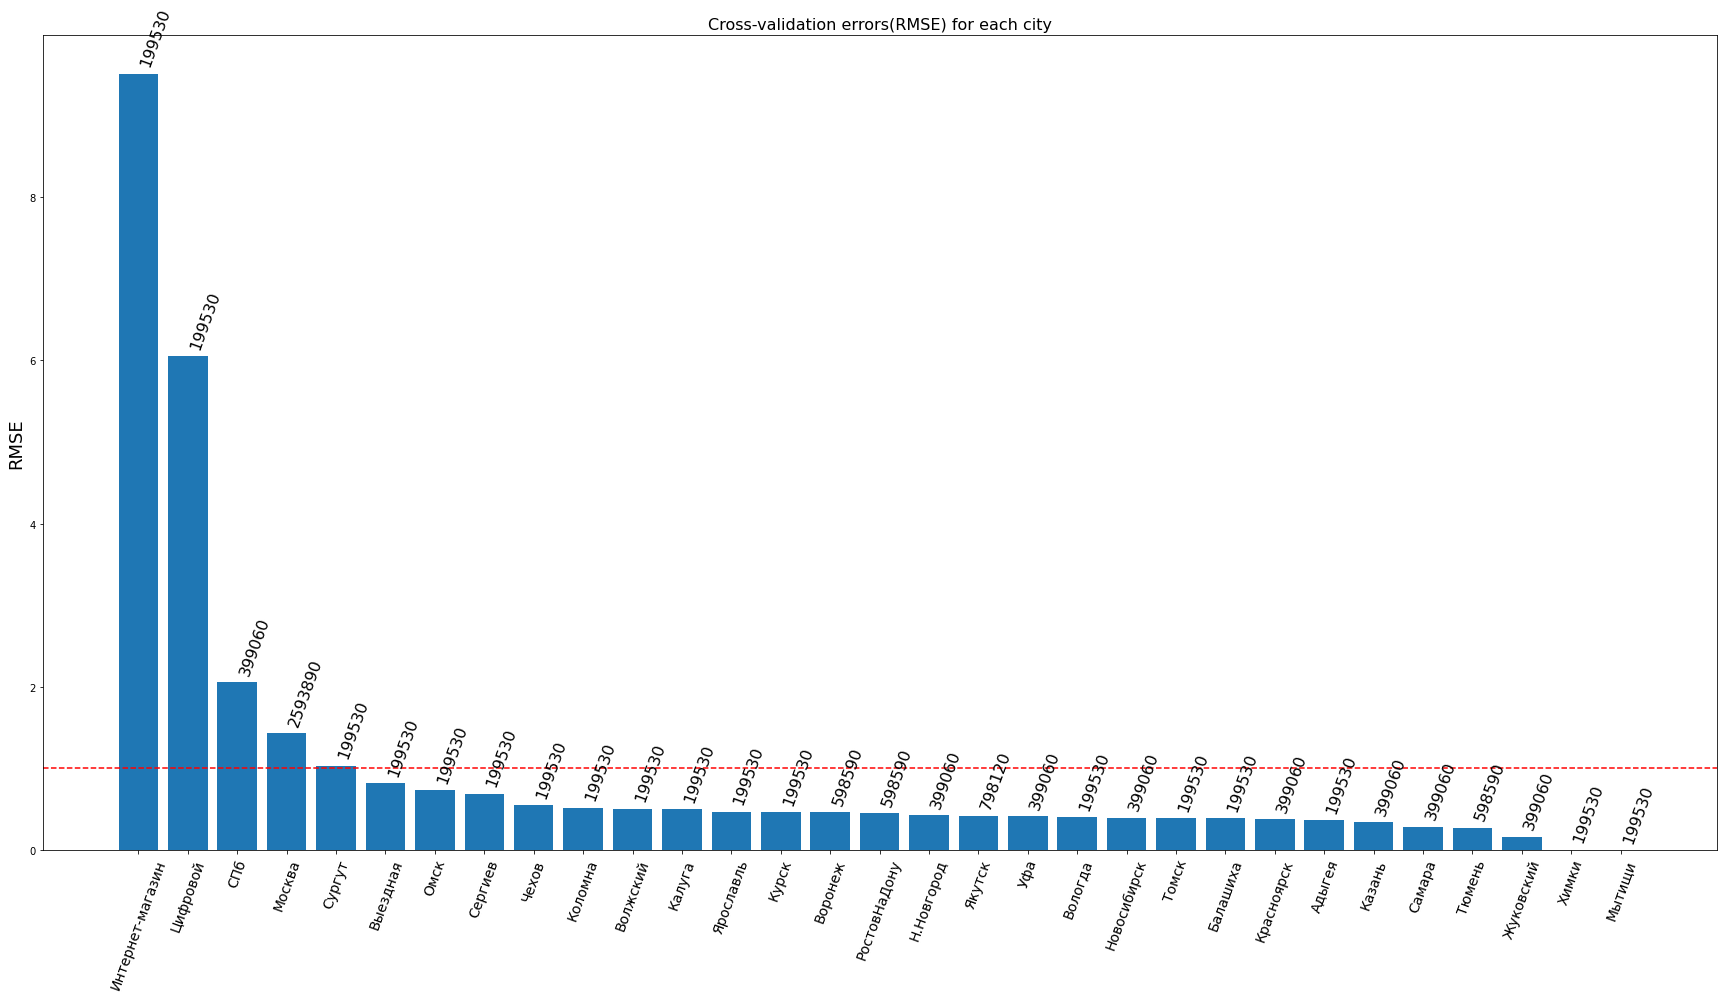

In [ ]:
plt.figure(figsize=(30, 15))
plt.title('Cross-validation errors(RMSE) for each city', size=16)
plot_errors(0, 'city')

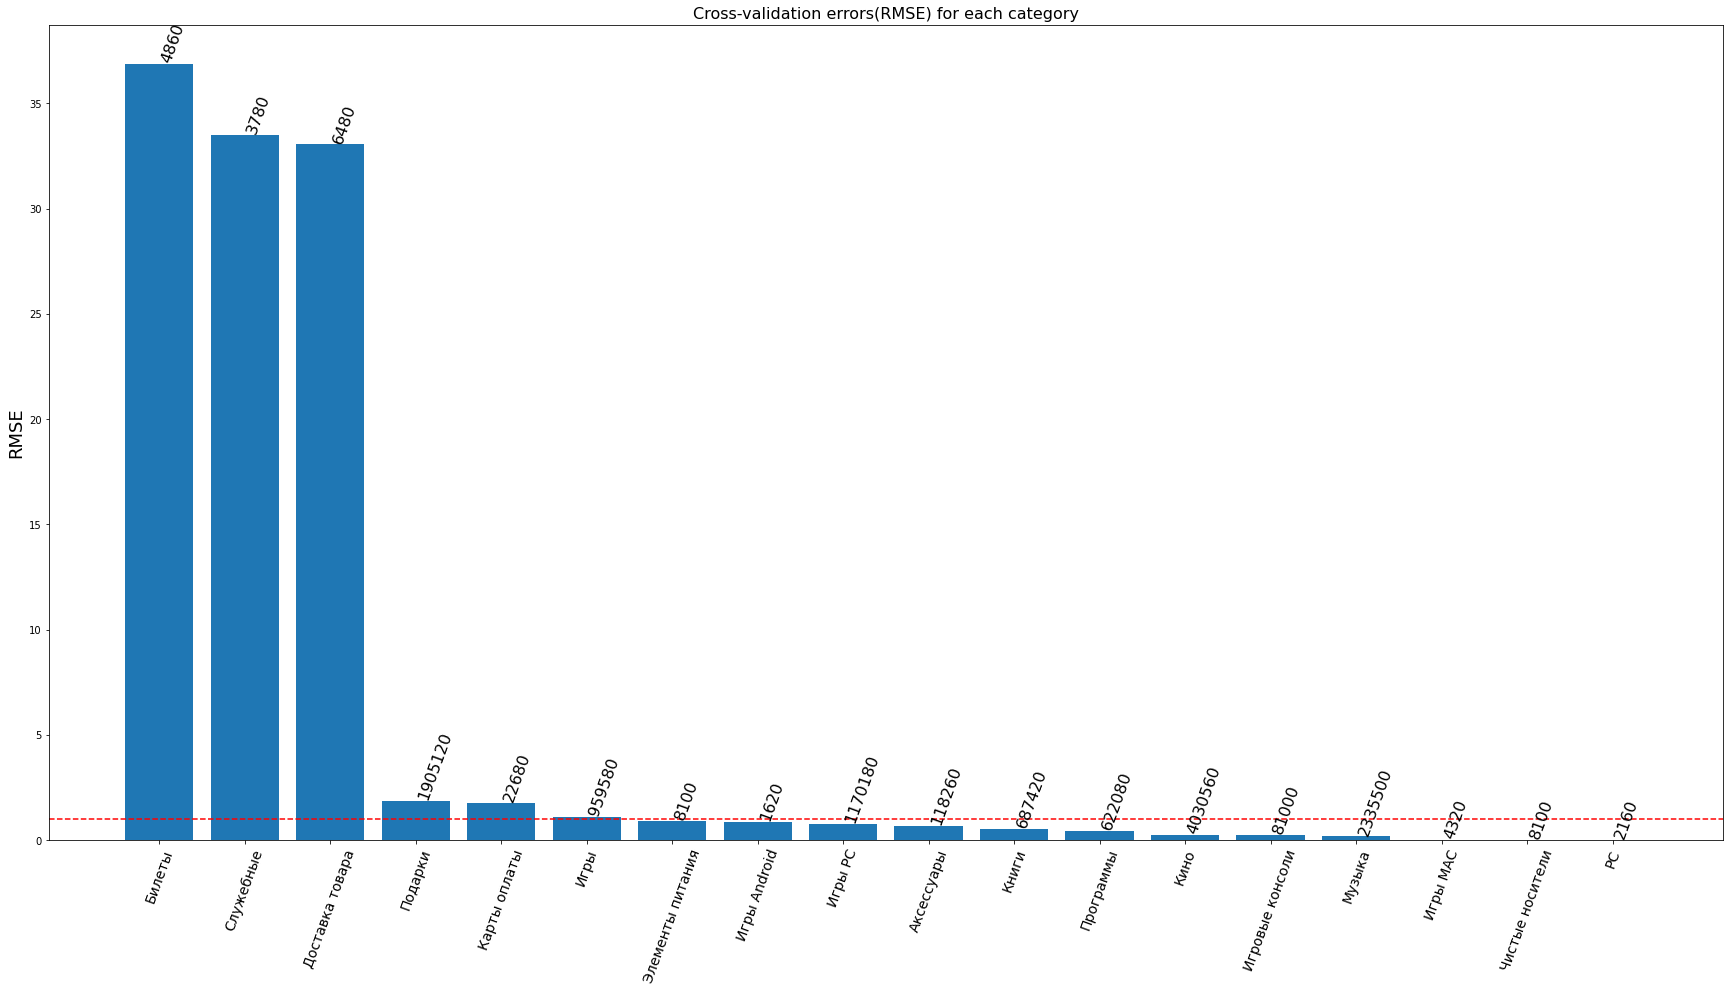

In [ ]:
plt.figure(figsize=(30, 15))
plt.title('Cross-validation errors(RMSE) for each category', size=16)
plot_errors(1, 'cat')

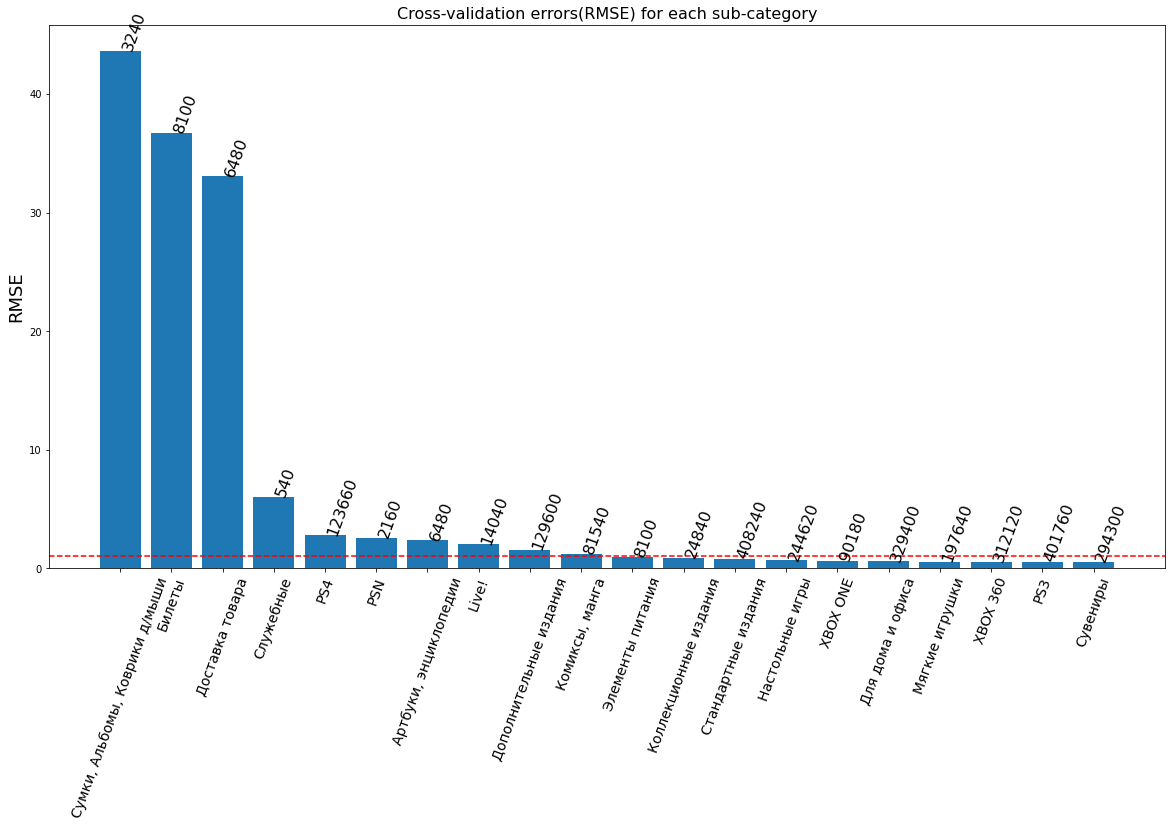

In [ ]:
plt.figure(figsize=(20, 10))
plt.title('Cross-validation errors(RMSE) for each sub-category', size=16)
plot_errors(2, 'sub_cat')

## Category sales vs predictions

#### Calculation

In [ ]:
data = pd.read_parquet('/content/drive/MyDrive/data/short_train.parquet')
data = data[['item_id', 'shop_id','city','cat', 'sub_cat','date_block_num', 'item_cnt_month']]

In [ ]:
preds, cats_std = category_prediction(categories,cols, X, y, model, months, 4)

In [ ]:
preds = np.load('/content/drive/MyDrive/data/preds_huber.npy', allow_pickle=True)

#### Full model


Sales for categories with singnificant errors



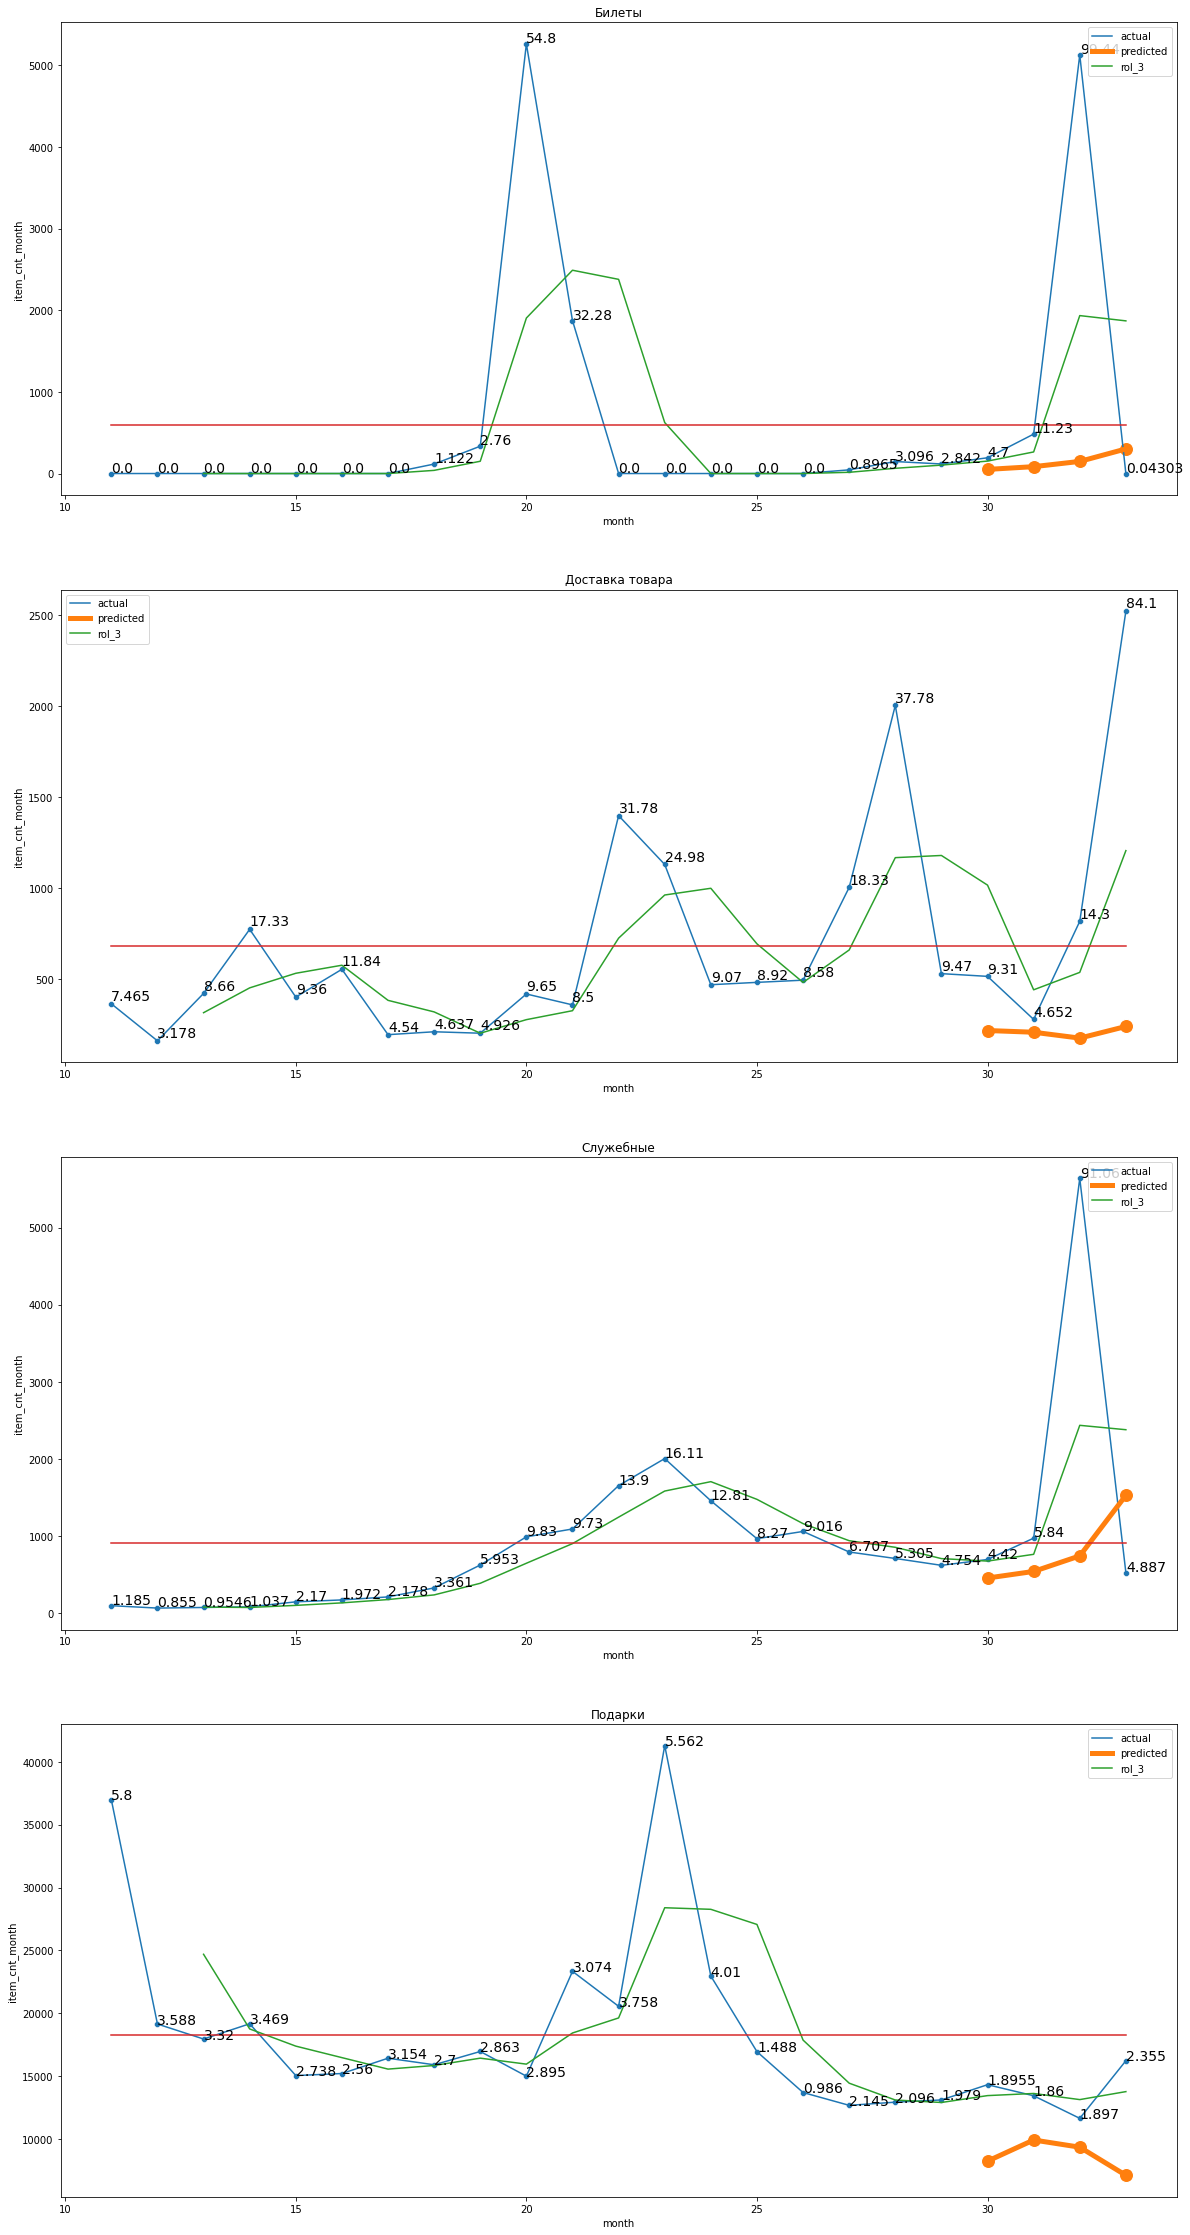

In [ ]:
print('\nSales for categories with singnificant errors\n')
cat_time = pd.DataFrame(data[data.cat.isin(bad_cats)].groupby(['cat','date_block_num'])['item_cnt_month'].sum()).reset_index(level=[0,1])
cat_time['std'] = data[data.cat.isin(bad_cats)].groupby(['cat','date_block_num'])['item_cnt_month'].std().to_list()
plt.figure(figsize=(20,40))
plot_cat_time(cat_time, bad_cats, 'item_cnt_month', 'cat')

Notes:

*   Most categories either have extremums in December/January or don't have them at all(From EDA)
*   Sales in category Tickets have seasonal extremums in September(but items from this categroiery appeared only in 17th month of observation)
*   Category Доставка товара has irregular peaks throughout obsercation time
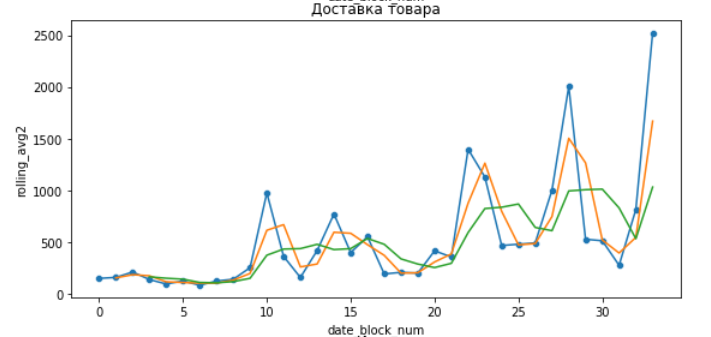




Sales for sub-categories with singnificant errors



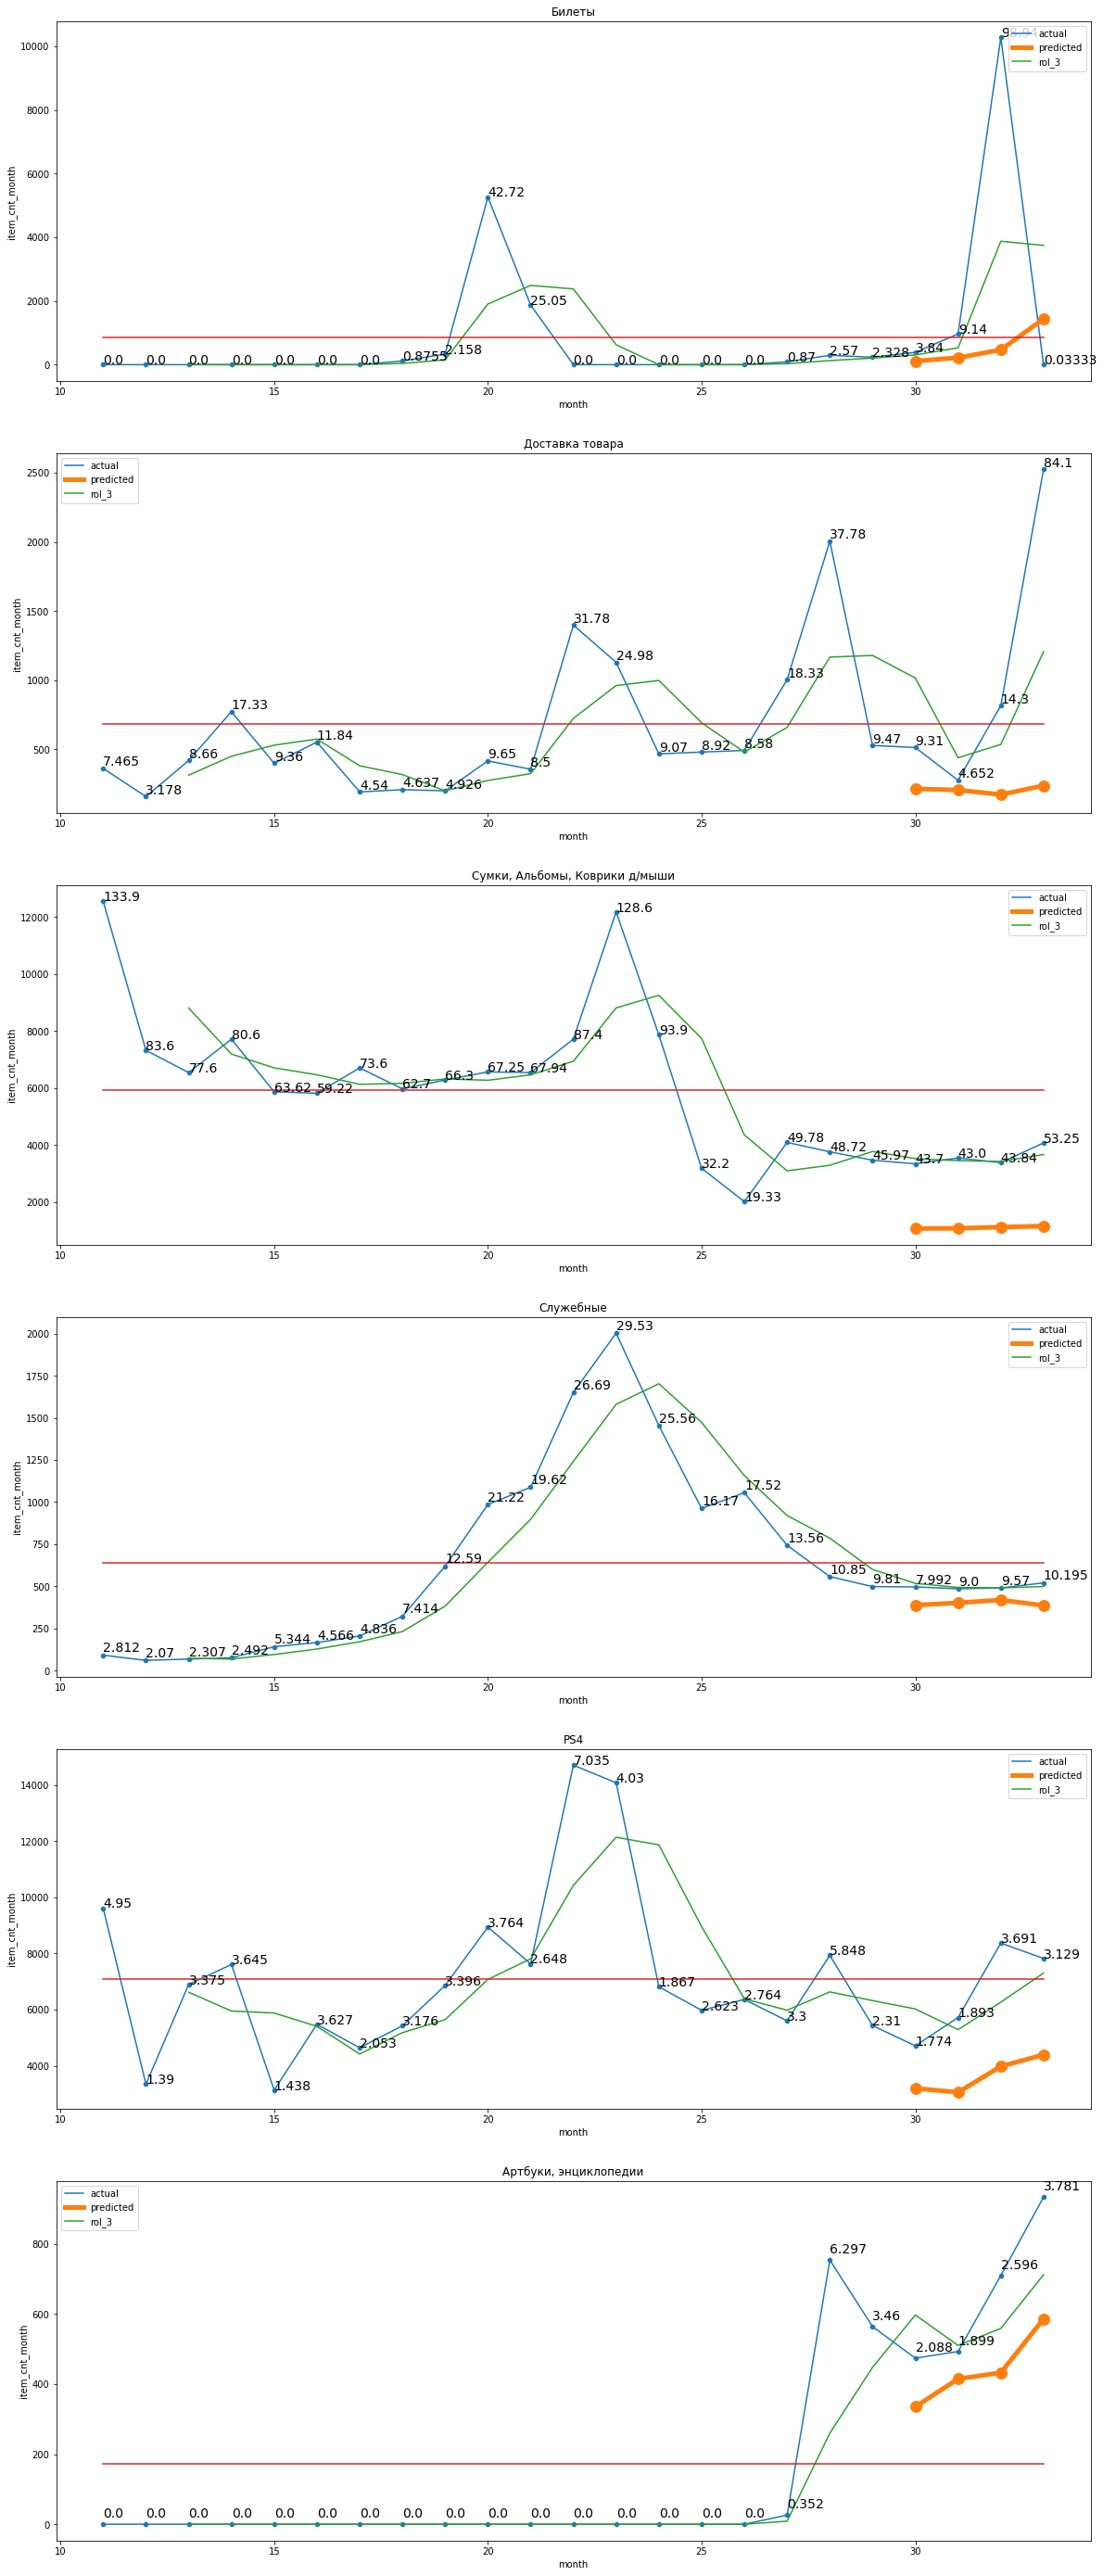

In [ ]:
print('\nSales for sub-categories with singnificant errors\n')
cat_time = pd.DataFrame(data[data.sub_cat.isin(bad_sub_cats)].groupby(['sub_cat','date_block_num'])['item_cnt_month'].sum()).reset_index(level=[0,1])
cat_time['std'] = data[data.sub_cat.isin(bad_sub_cats)].groupby(['sub_cat','date_block_num'])['item_cnt_month'].std().to_list()
plt.figure(figsize=(20,50))
plot_cat_time(cat_time, bad_sub_cats, 'item_cnt_month', 'sub_cat')


Sales for categories with singnificant errors



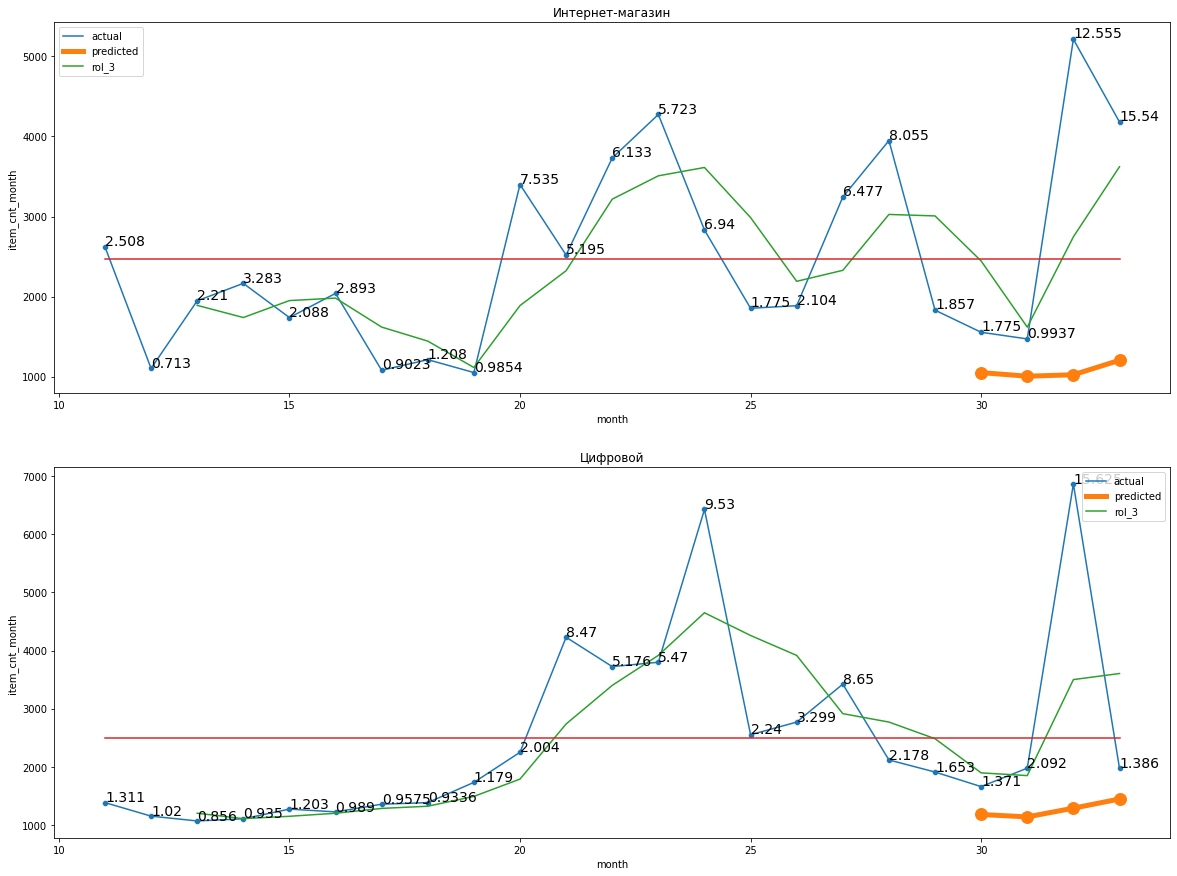

In [ ]:
print('\nSales for categories with singnificant errors\n')
cat_time = pd.DataFrame(data[data.city.isin(bad_cities)].groupby(['city','date_block_num'])['item_cnt_month'].sum()).reset_index(level=[0,1])
cat_time['std'] = data[data.city.isin(bad_cities)].groupby(['city','date_block_num'])['item_cnt_month'].std().to_list()
plt.figure(figsize=(20,15))
plot_cat_time(cat_time, bad_cities, 'item_cnt_month', 'city')

#### Split model

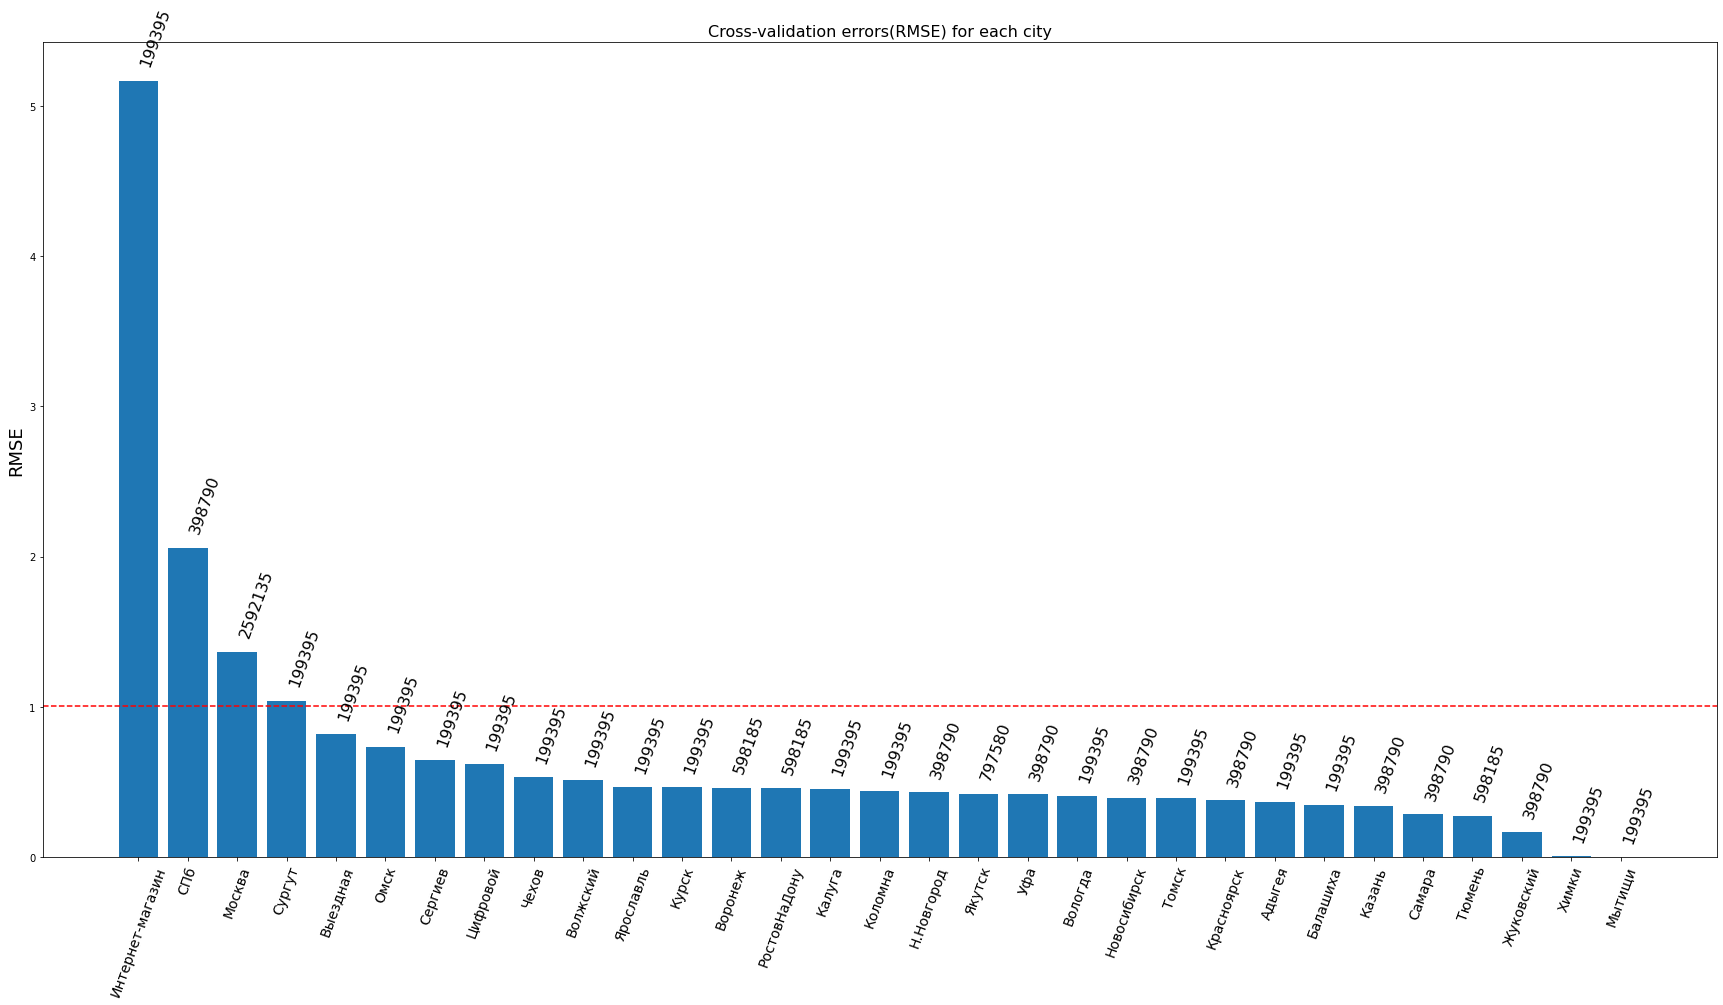

In [ ]:
plt.figure(figsize=(30, 15))
plt.title('Cross-validation errors(RMSE) for each city', size=16)
plot_errors(0, 'city')

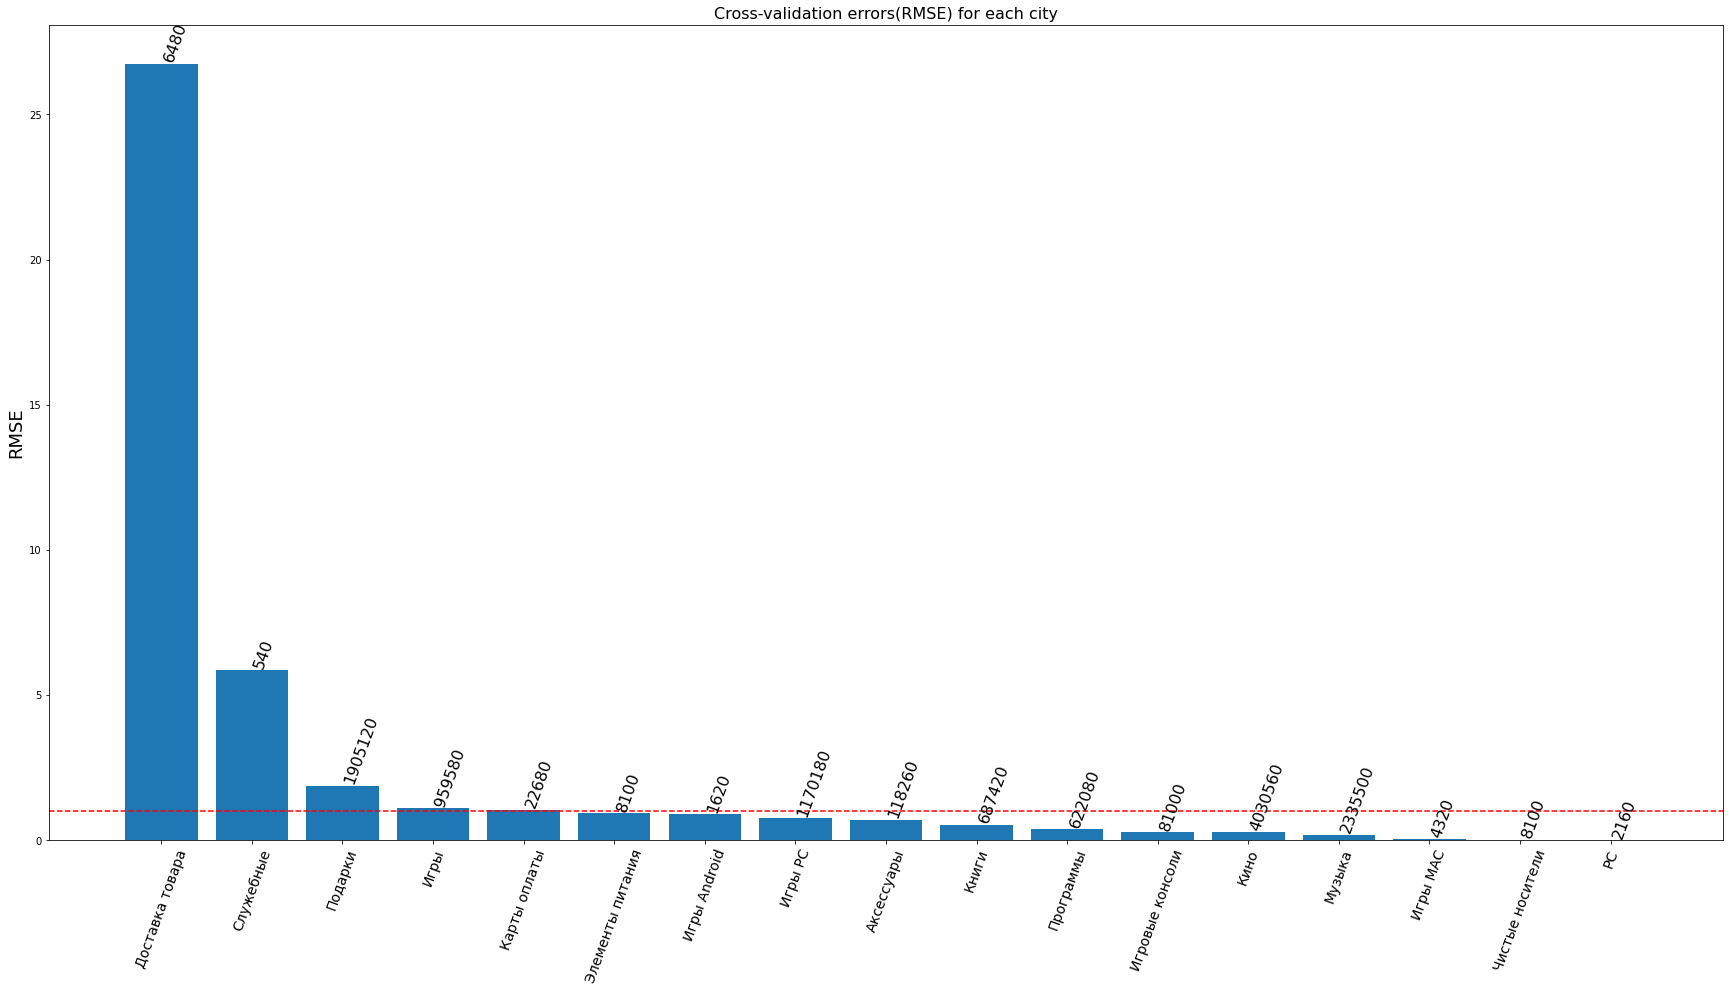

In [ ]:
plt.figure(figsize=(30, 15))
plt.title('Cross-validation errors(RMSE) for each city', size=16)
plot_errors(1, 'cat')


Sales for categories with singnificant errors



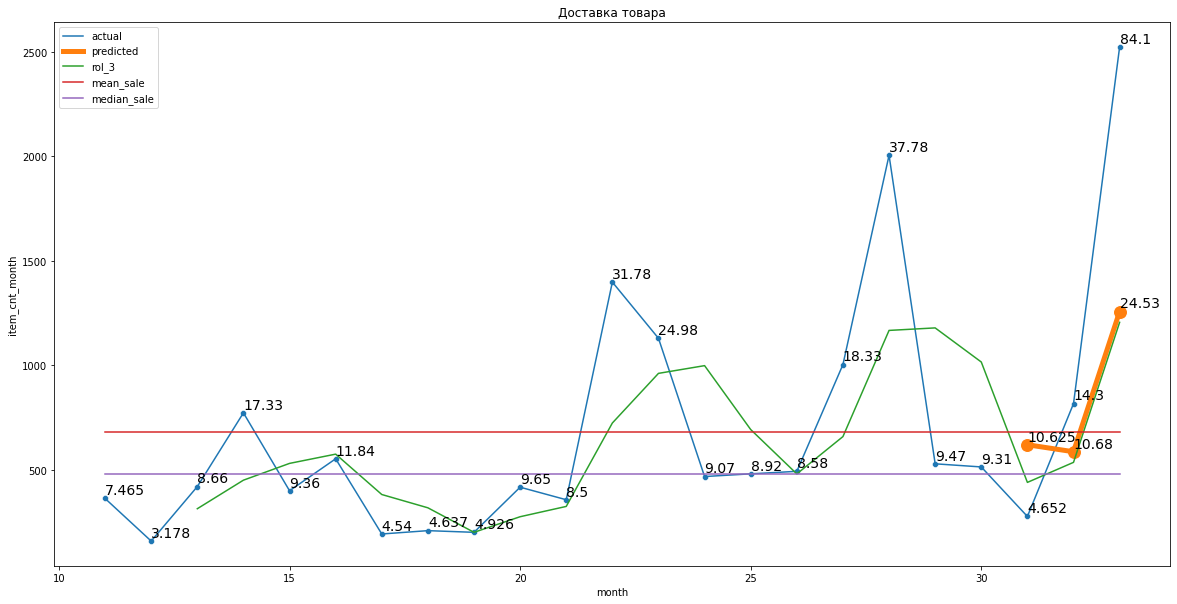

In [ ]:
print('\nSales for categories with singnificant errors\n')
cat_time = pd.DataFrame(data[data.cat.isin([3])].groupby(['cat','date_block_num'])['item_cnt_month'].sum()).reset_index(level=[0,1])
cat_time['std'] = data[data.cat.isin([3])].groupby(['cat','date_block_num'])['item_cnt_month'].std().to_list()
plt.figure(figsize=(20,10))
plot_cat_time(cat_time, [3], 'item_cnt_month', 'cat')


Sales for categories with singnificant errors



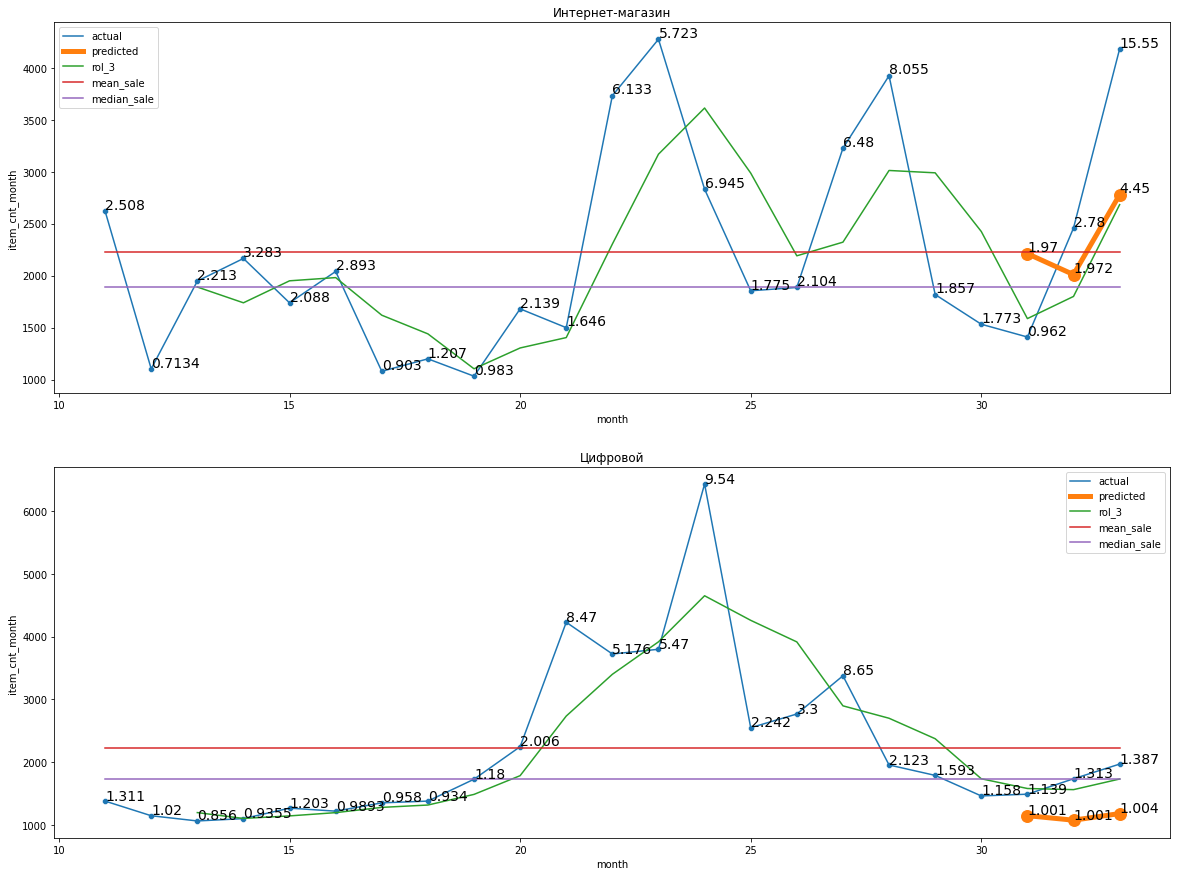

In [ ]:
print('\nSales for categories with singnificant errors\n')
cat_time = pd.DataFrame(data[data.city.isin(bad_cities)].groupby(['city','date_block_num'])['item_cnt_month'].sum()).reset_index(level=[0,1])
cat_time['std'] = data[data.city.isin(bad_cities)].groupby(['city','date_block_num'])['item_cnt_month'].std().to_list()
plt.figure(figsize=(20,15))
plot_cat_time(cat_time, bad_cities, 'item_cnt_month', 'city')

#### Tickets


Sales for categories with singnificant errors



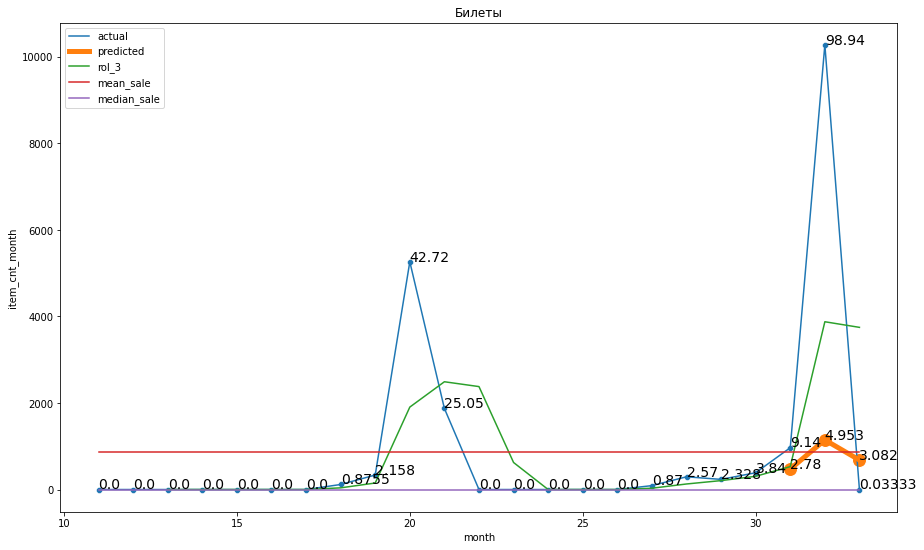

In [ ]:
print('\nSales for categories with singnificant errors\n')
cat_time = pd.DataFrame(data[data.sub_cat.isin([25])].groupby(['sub_cat','date_block_num'])['item_cnt_month'].sum()).reset_index(level=[0,1])
cat_time['std'] = data[data.sub_cat.isin([25])].groupby(['sub_cat','date_block_num'])['item_cnt_month'].std().to_list()
plt.figure(figsize=(15,9))
plot_cat_time(cat_time, [25], 'item_cnt_month', 'sub_cat')

## Items with huge rmse

### Prepare

In [ ]:
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
items = pd.merge(items, item_categories, on='item_category_id', how='left')

In [ ]:
items_errors = pd.read_csv('items_errors.csv')
items_errors.columns = ['item_id', 'rmse']

In [ ]:
items = pd.merge(items, items_errors, on='item_id', how='left')

In [ ]:
data = pd.read_parquet(data_path)
data = data[['item_id', 'shop_id','city','cat', 'sub_cat','date_block_num', 'item_cnt_month']]

### Items errors

In [ ]:
bad_items = items_errors.head(15)['item_id']

In [ ]:
bad_items_df = items[items.item_id.isin(bad_items)]
bad_items_df

item_name  item_id  \
3351                       FIFA 16 [PS4, русская версия]     3351   
9244   Билет "ИгроМир 2015" - 2 октября 2015 (сайт) [...     9244   
9245   Билет "ИгроМир 2015" - 2 октября 2015 (сайт) У...     9245   
9246   Билет "ИгроМир 2015" - 2 октября 2015 [Цифрова...     9246   
9247   Билет "ИгроМир 2015" - 2 октября 2015 УПР [Циф...     9247   
9248   Билет "ИгроМир 2015" - 3 октября 2015 (сайт) [...     9248   
9249   Билет "ИгроМир 2015" - 3 октября 2015 (сайт) У...     9249   
9250   Билет "ИгроМир 2015" - 3 октября 2015 [Цифрова...     9250   
9251   Билет "ИгроМир 2015" - 3 октября 2015 УПР [Циф...     9251   
9252   Билет "ИгроМир 2015" - 4 октября 2015 (сайт) [...     9252   
9253   Билет "ИгроМир 2015" - 4 октября 2015 (сайт) У...     9253   
9255   Билет "ИгроМир 2015" - 4 октября 2015 УПР [Циф...     9255   
11370                               Доставка (по Москве)    11370   
11373               Доставка до пункта выдачи (Boxberry)    11373   
20949  Фирменный пакет майка 1С Интерес белый (34*42)...    20949   

       item_category_id                        item_category_name       rmse  
3351                 20                                Игры - PS4  13.836913  
9244                 80                        Служебные - Билеты  26.737115  
9245                  8                            Билеты (Цифра)  26.612928  
9246                 80                        Служебные - Билеты  12.608130  
9247                  8                            Билеты (Цифра)  38.073912  
9248                 80                        Служебные - Билеты  71.430873  
9249                  8                            Билеты (Цифра)  71.335841  
9250                 80                        Служебные - Билеты  16.857512  
9251                  8                            Билеты (Цифра)  57.908246  
9252                 80                        Служебные - Билеты  22.564391  
9253                  8                            Билеты (Цифра)  22.481308  
9255                  8                            Билеты (Цифра)  25.918087  
11370                 9                           Доставка товара  16.499589  
11373                 9                           Доставка товара  19.599530  
20949                71  Подарки - Сумки, Альбомы, Коврики д/мыши  98.643218

In [ ]:
def plot_item_shop(item_id, shop_id=None):
    if shop_id is None:
        check = data[(data.item_id == item_id)]
    else:
        check = data[(data.item_id == item_id)&(data.shop_id == shop_id)]
    check = check.groupby('date_block_num')[['item_cnt_month']].sum().reset_index()
    sns.scatterplot(x = check.date_block_num,y = check.item_cnt_month)
    plt.plot(check.date_block_num, check.item_cnt_month)
    plt.show()

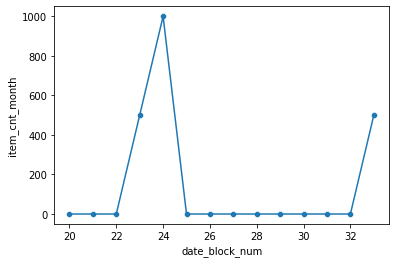

In [ ]:
plot_item_shop(20949, 12)

3240 entries in dataset for this subcategory with average of 202911 entries

RMSE:   71.43087303251245


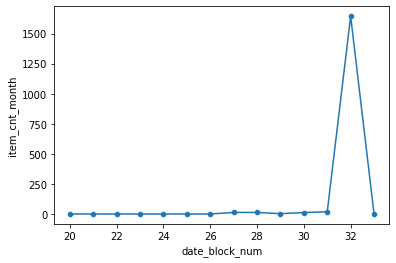

RMSE:   71.33584098716905


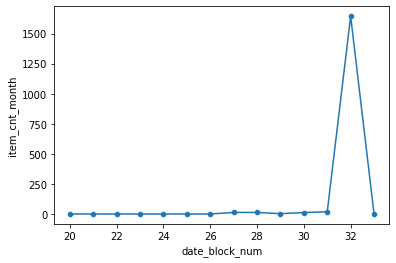

RMSE:   57.908246143117616


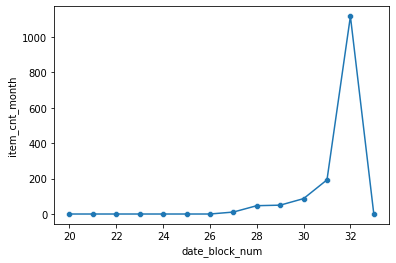

RMSE:   38.073911703849234


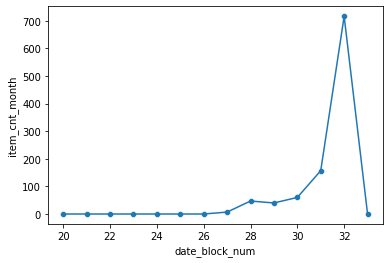

RMSE:   26.737115441774147


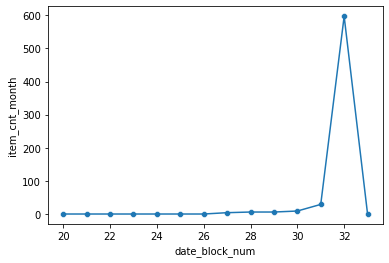

RMSE:   26.61292760591748


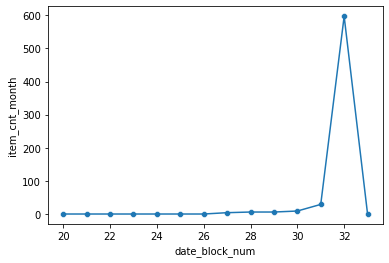

RMSE:   25.918086753914935


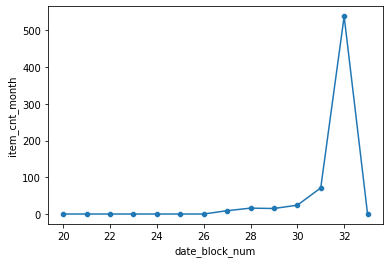

RMSE:   22.564390671120822


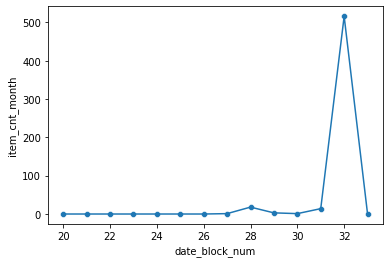

RMSE:   22.481308067538745


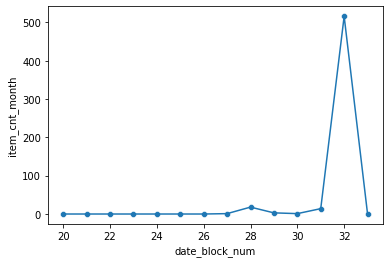

RMSE:   19.59952966031877


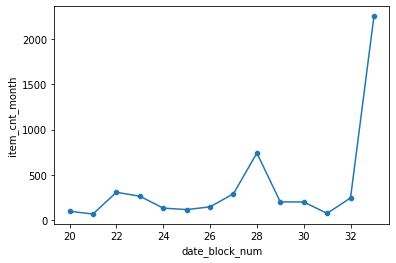

RMSE:   16.857512376644333


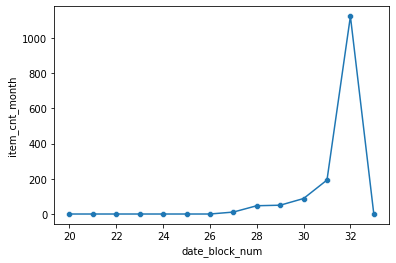

RMSE:   16.499589306665982


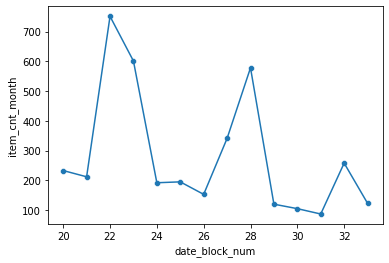

RMSE:   13.83691322951786


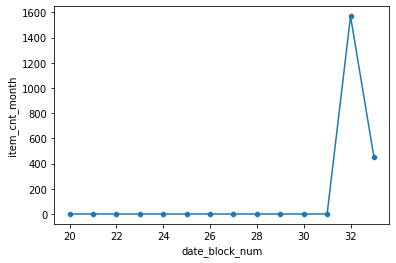

RMSE:   12.608129822966818


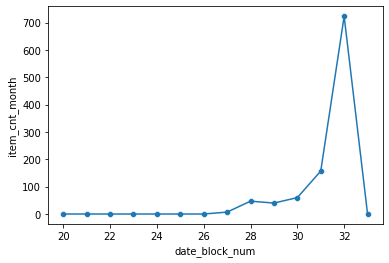

In [ ]:
for ind in bad_items[1:]:
    print('RMSE:  ', bad_items_df[bad_items_df.item_id == ind][['rmse']].iloc[0,0] )
    plot_item_shop(ind)

## SHAP for categories

In [ ]:
explainer = TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [ ]:
np.save('/content/drive/MyDrive/data/shap.npy', shap_values)

In [ ]:
shap_values = np.load('/content/drive/MyDrive/data/shap.npy')

In [ ]:
decoder = CategoryDecoder('cats.csv','sub_cats.csv', 'cities.csv')

Билеты


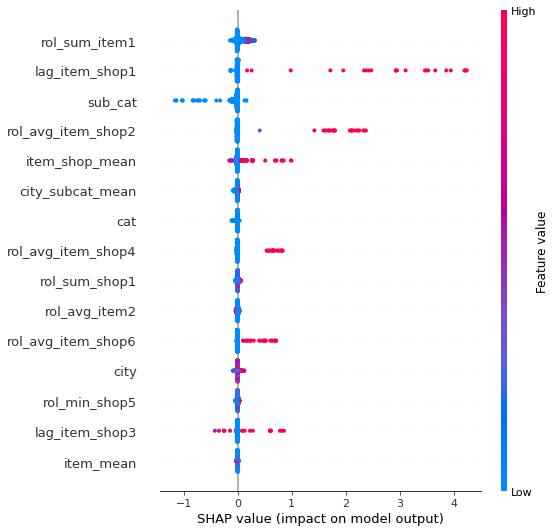

Доставка товара


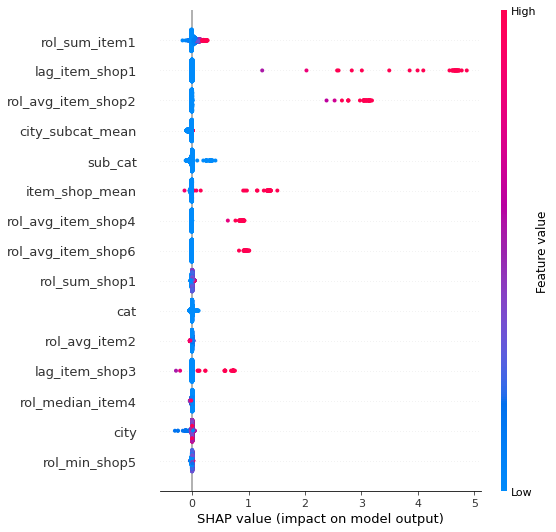

Служебные


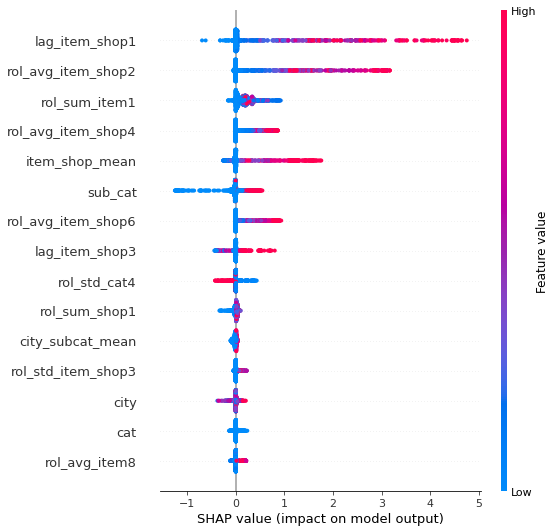

Подарки


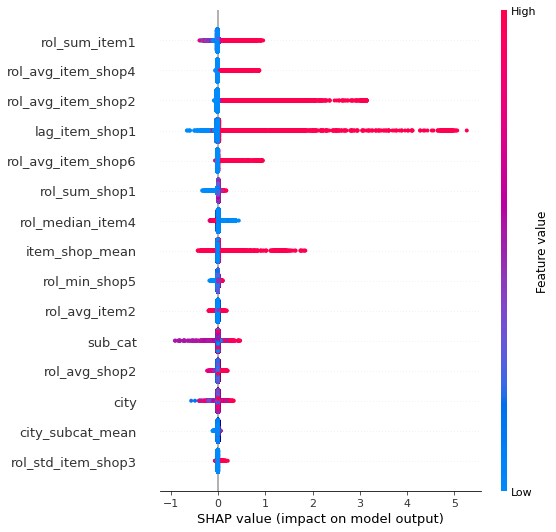

In [ ]:
for i in bad_cats:
    mask = X[:,2] == i
    print(decoder._decode('cat',i))
    shap.summary_plot(shap_values[mask], X[mask], feature_names=num_cols, max_display=15)

Интернет-магазин


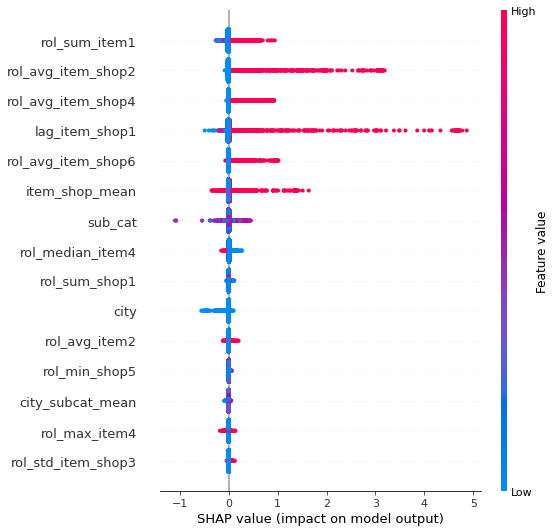

Цифровой


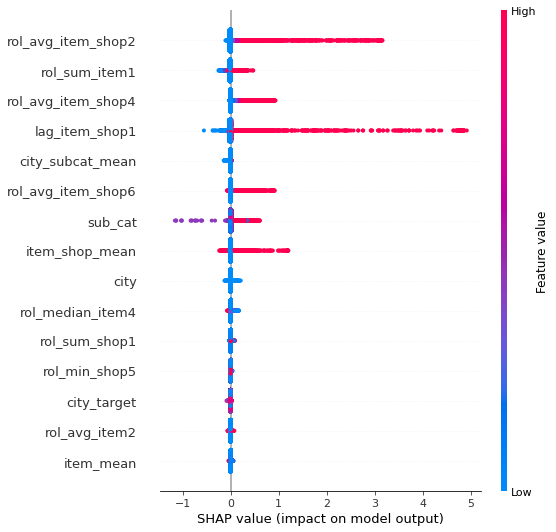

In [ ]:
for i in bad_cities:
    mask = X[:,1] == i
    print(decoder._decode('city',i))
    shap.summary_plot(shap_values[mask], X[mask], feature_names=num_cols, max_display=15)

PC


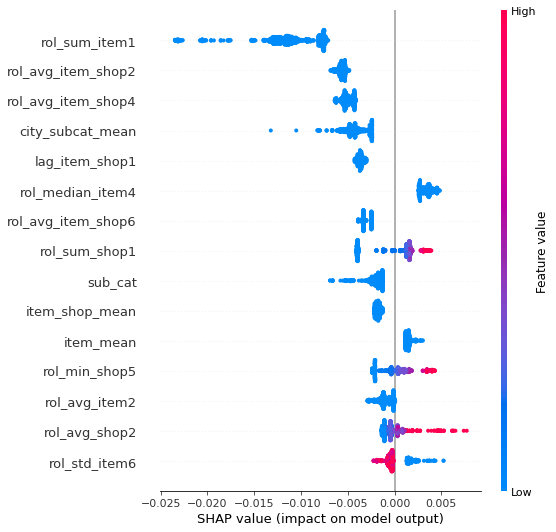

Аксессуары


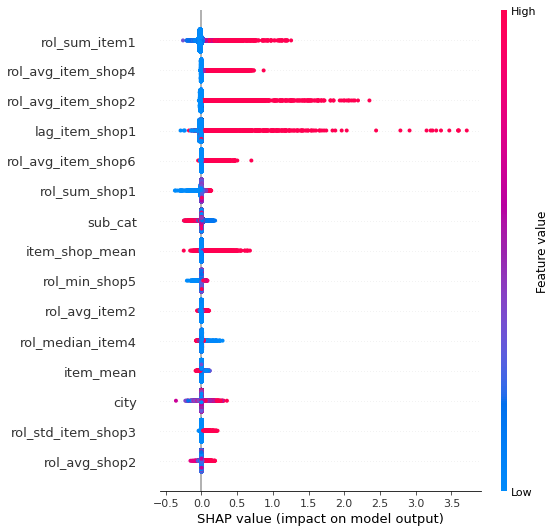

Билеты


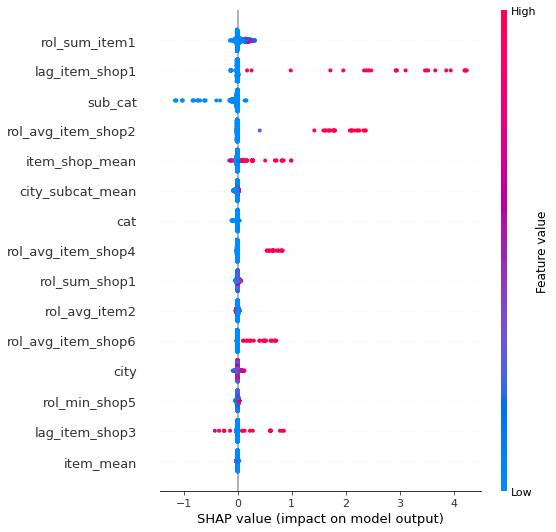

Доставка товара


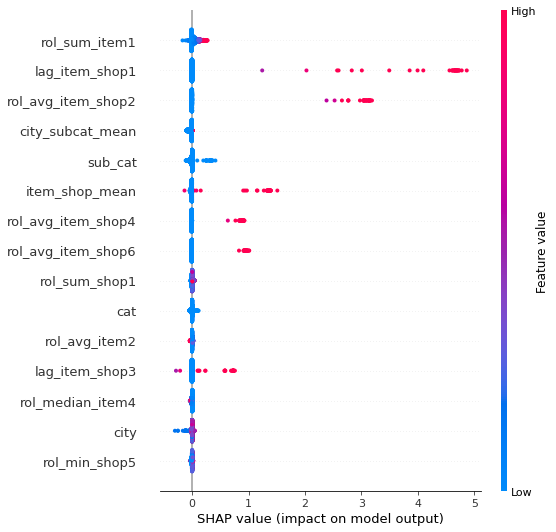

Игровые консоли


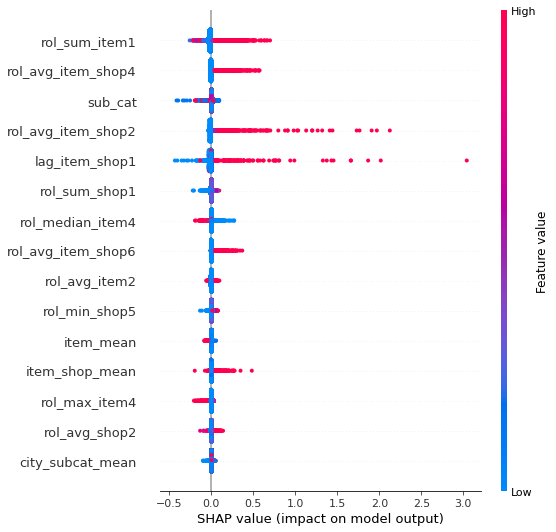

Игры


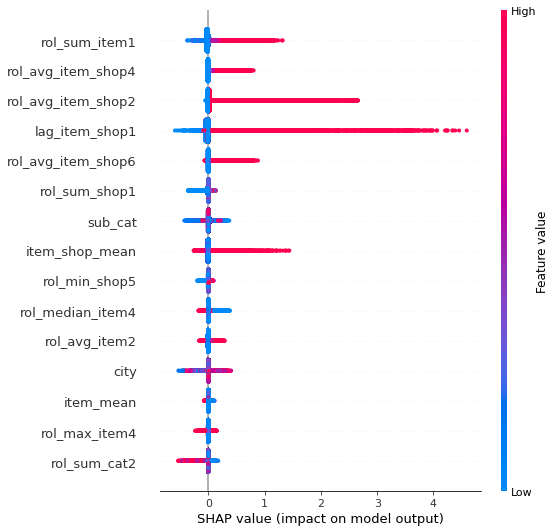

Игры Android


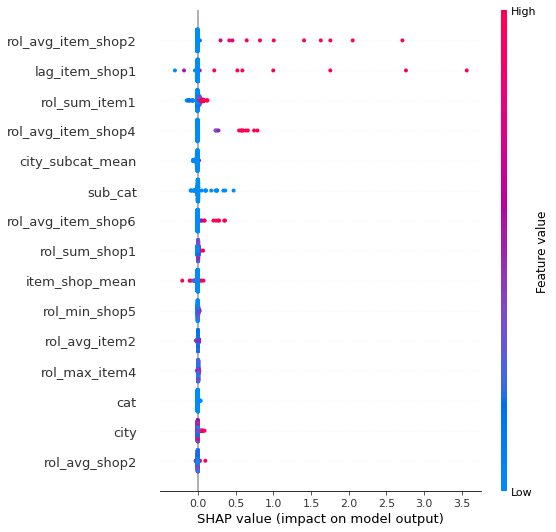

Игры MAC


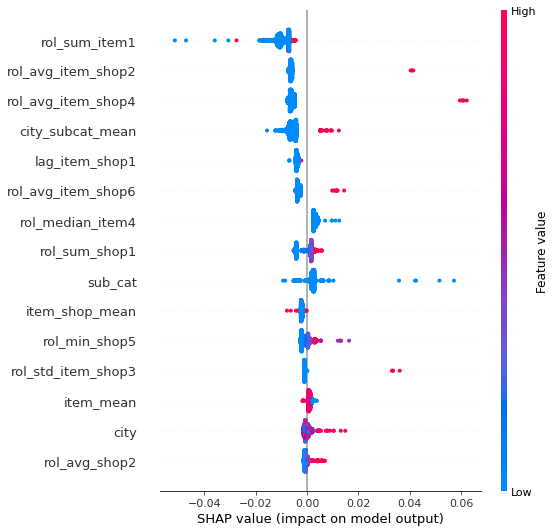

Игры PC


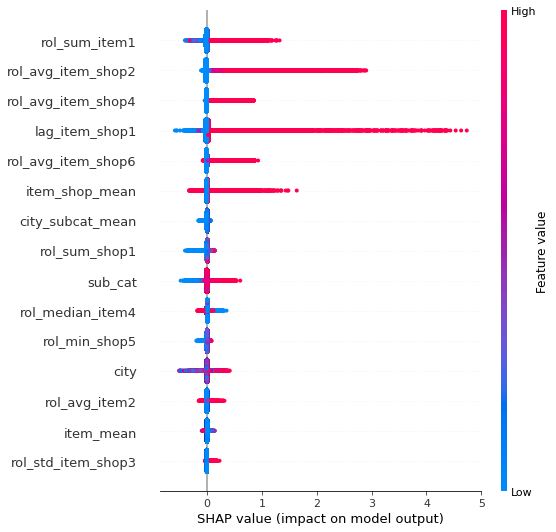

Карты оплаты


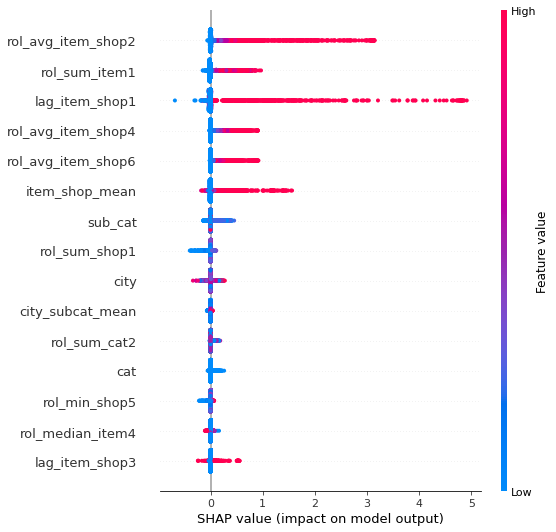

Кино


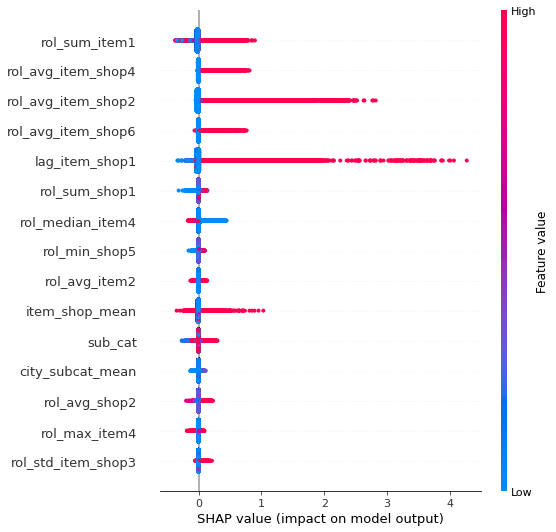

Книги


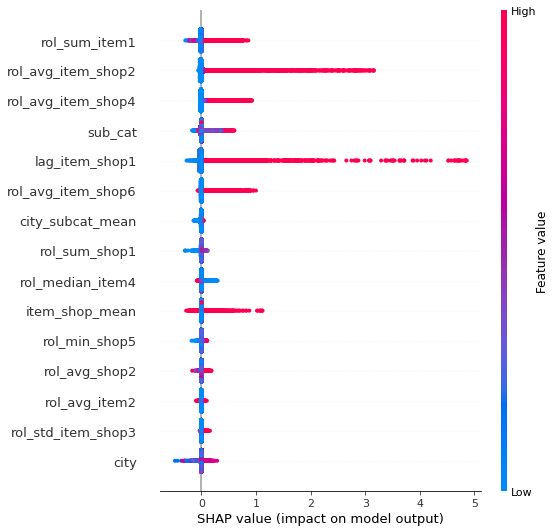

Музыка


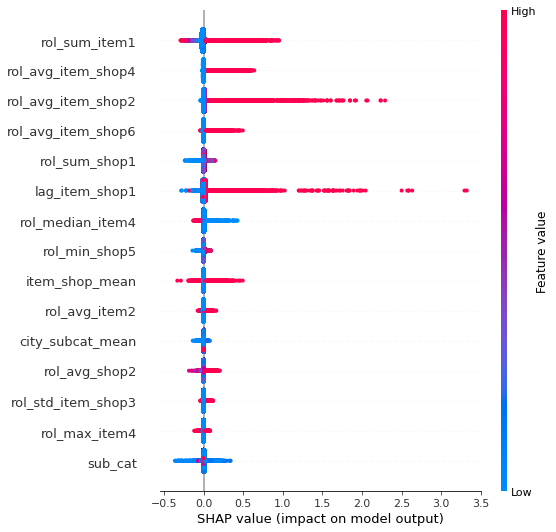

Подарки


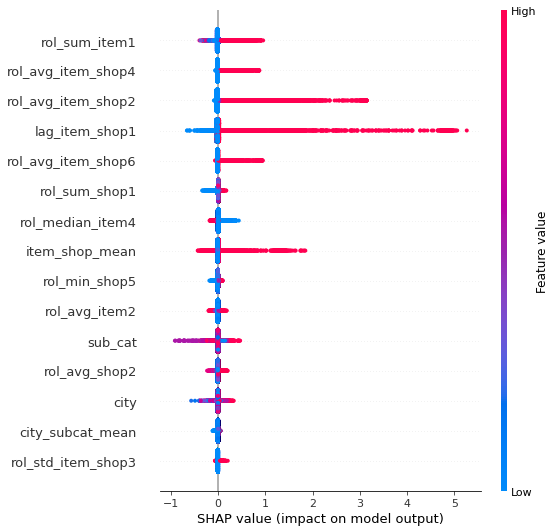

Программы


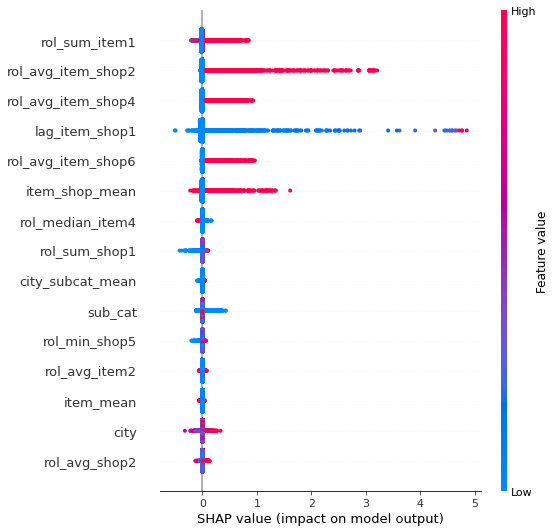

Служебные


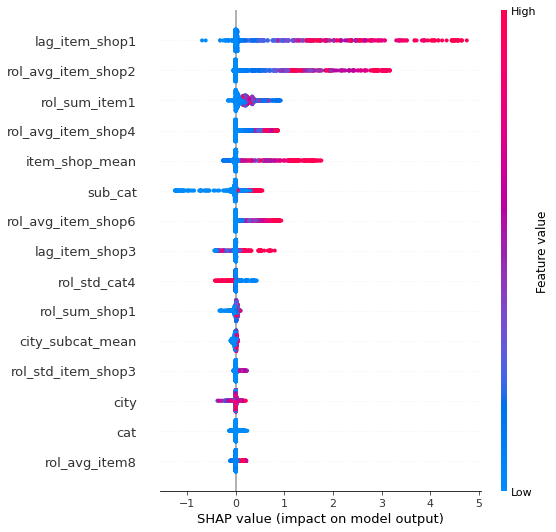

Чистые носители


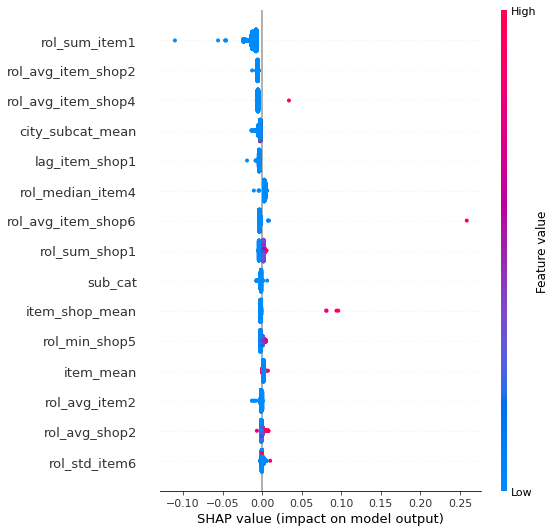

Элементы питания


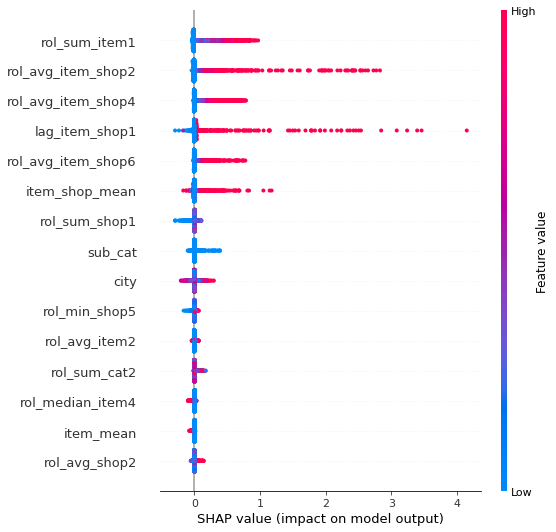

In [ ]:
for i in range(len(cats)):
    mask = X[:,2] == i
    print(decoder._decode('cat',i))
    shap.summary_plot(shap_values[mask], X[mask], feature_names=num_cols, max_display=15)

Адыгея


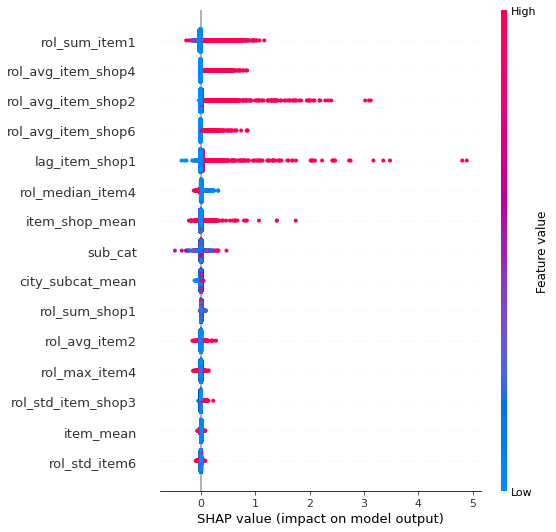

Балашиха


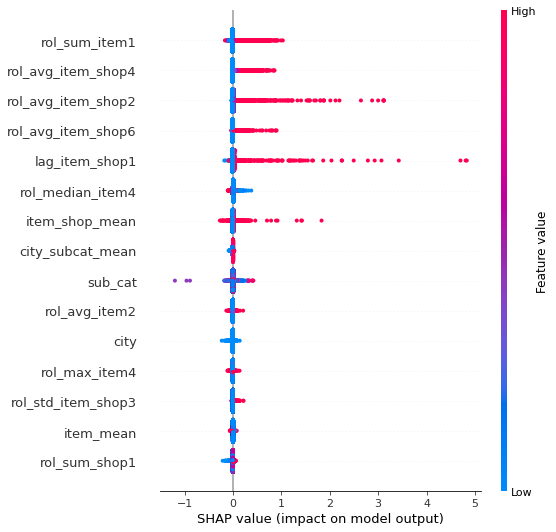

Волжский


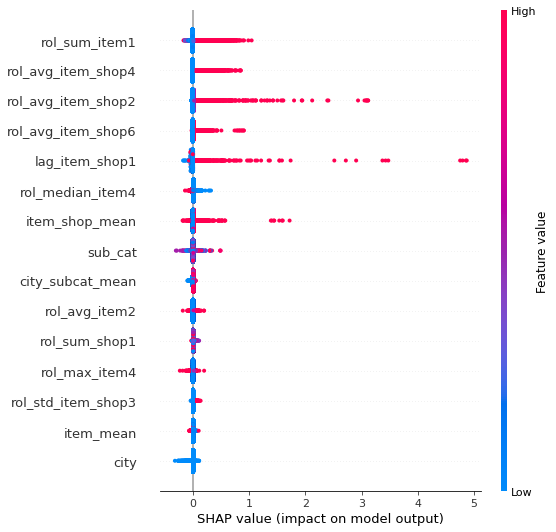

Вологда


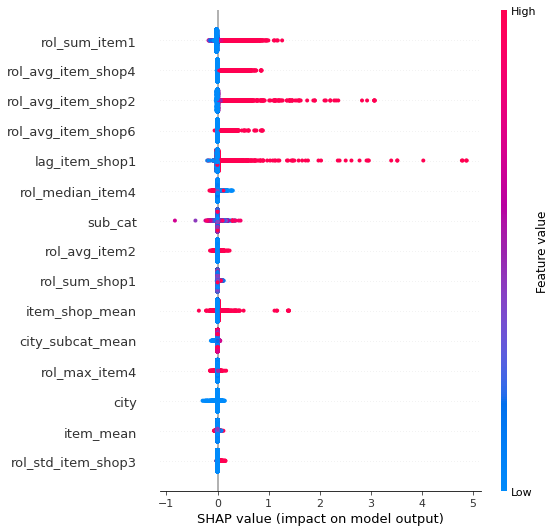

Воронеж


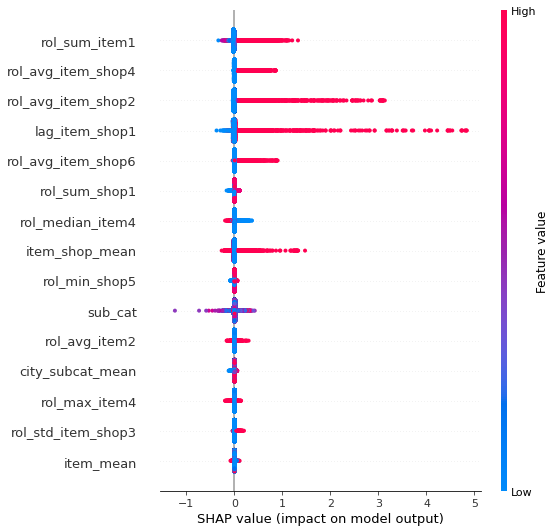

Выездная


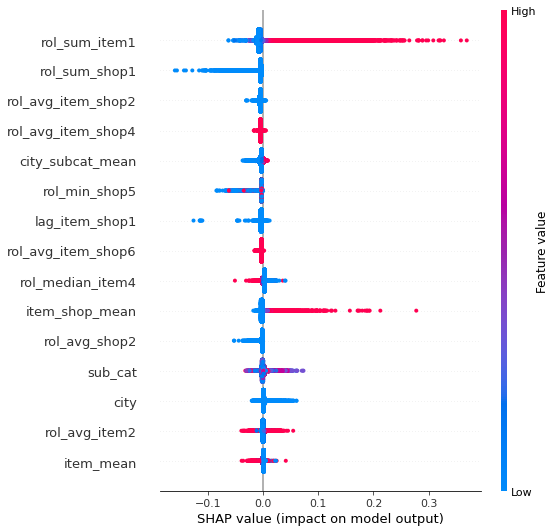

Жуковский


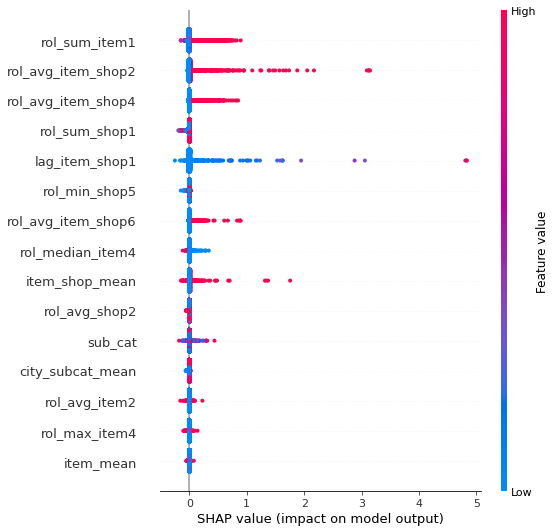

Интернет-магазин


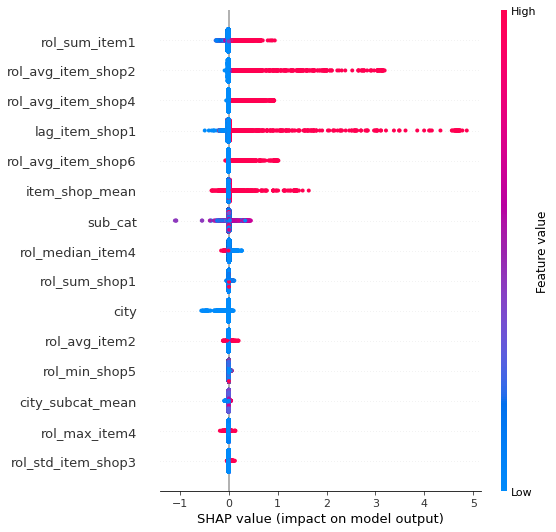

Казань


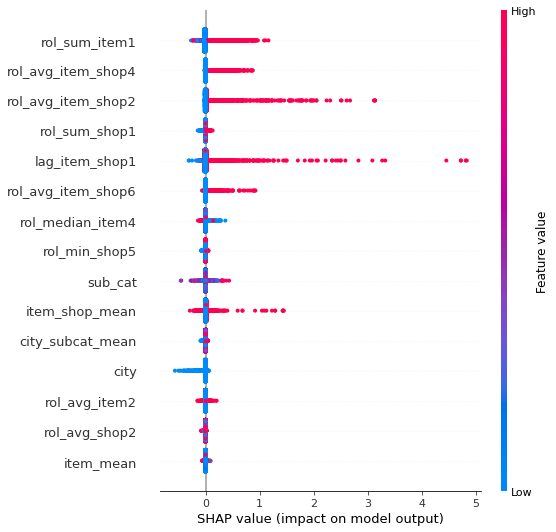

Калуга


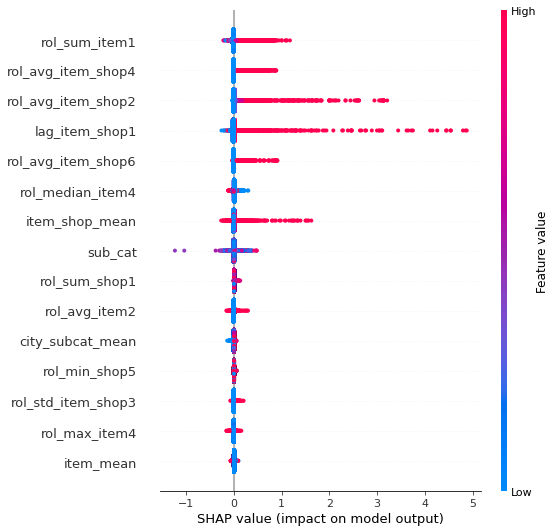

Коломна


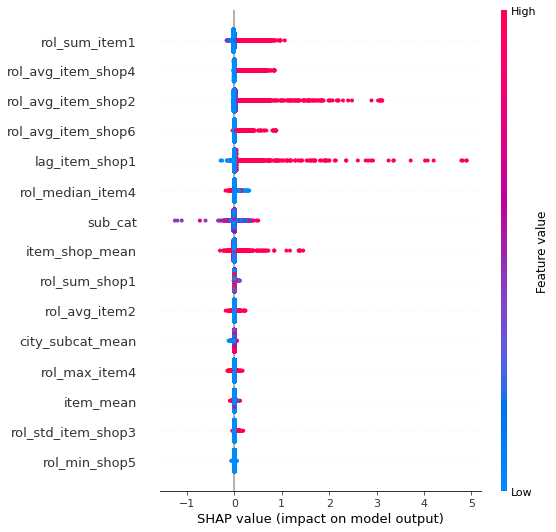

Красноярск


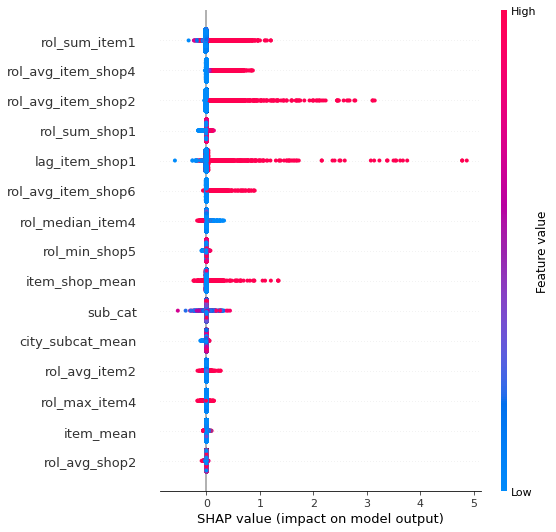

Курск


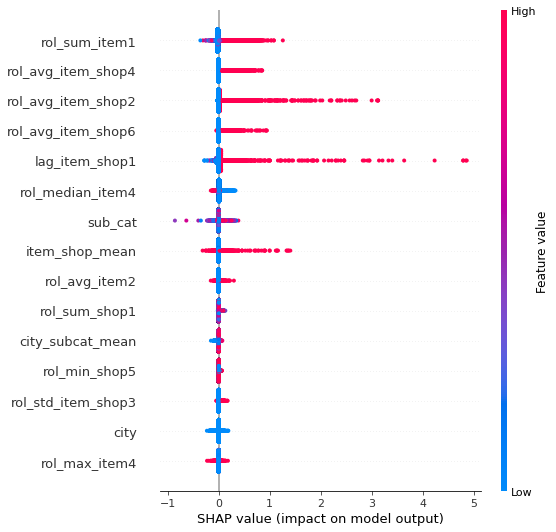

Москва


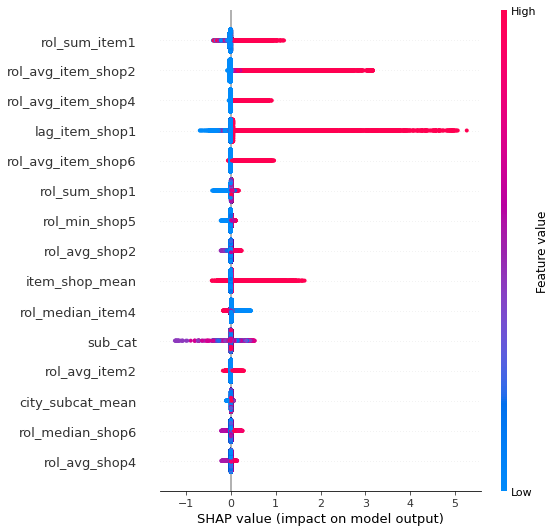

Мытищи


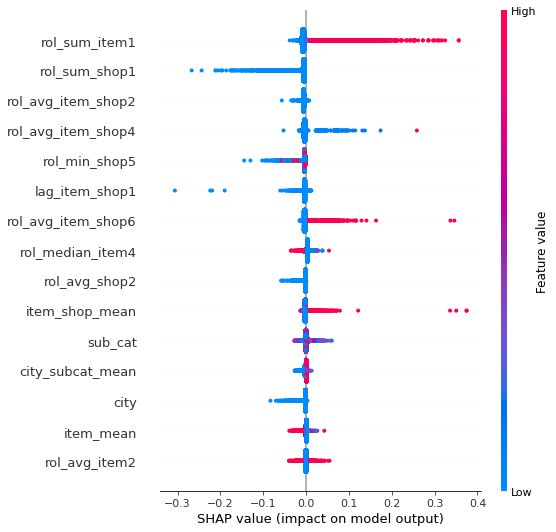

Н.Новгород


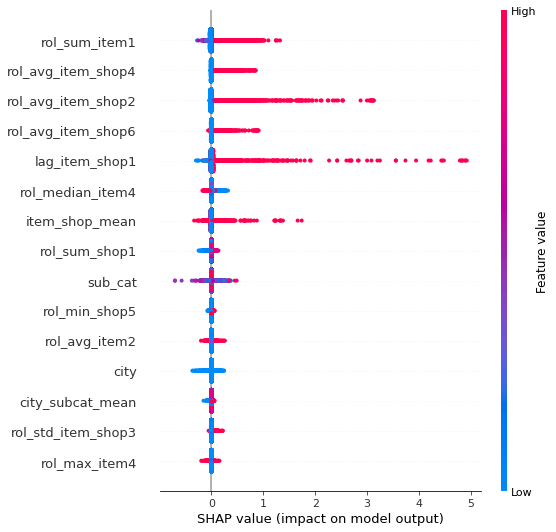

Новосибирск


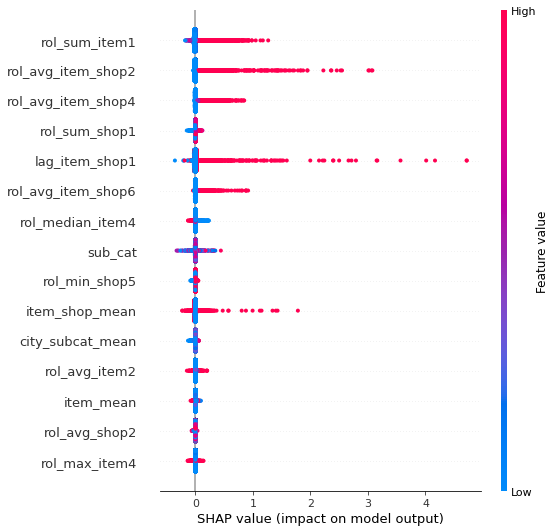

Омск


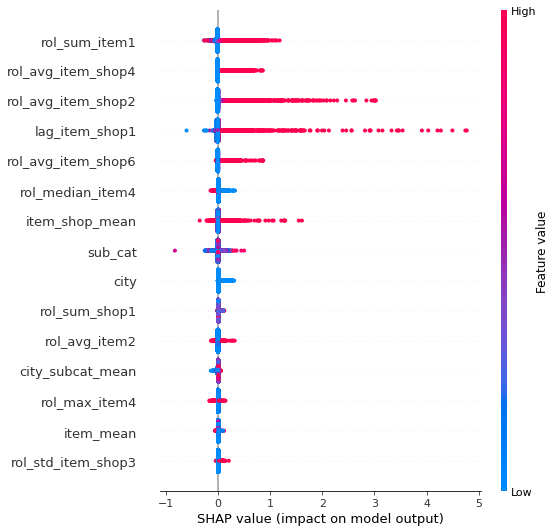

РостовНаДону


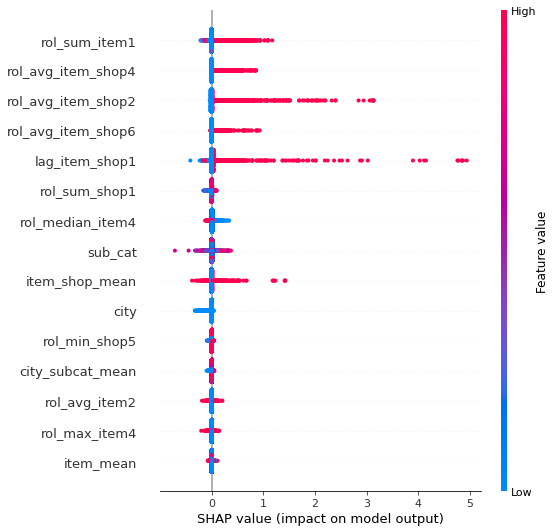

СПб


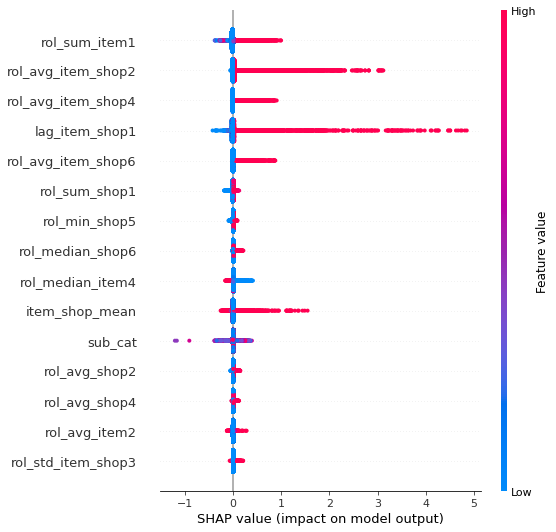

Самара


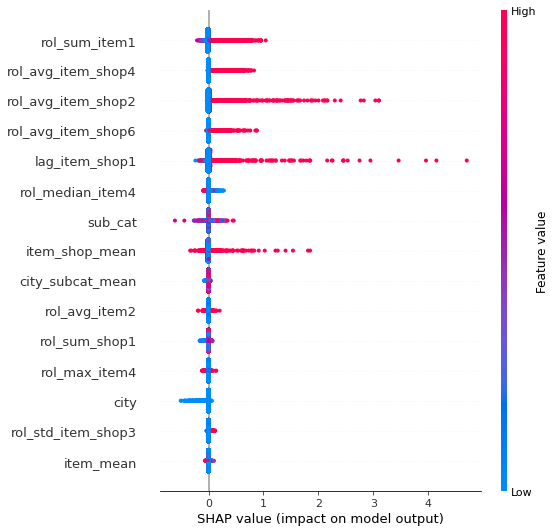

Сергиев


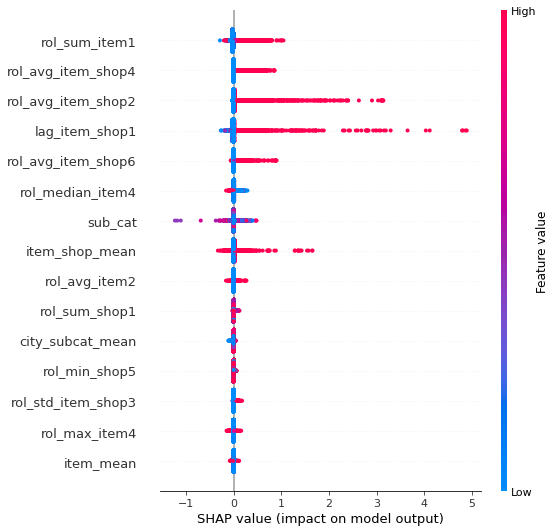

Сургут


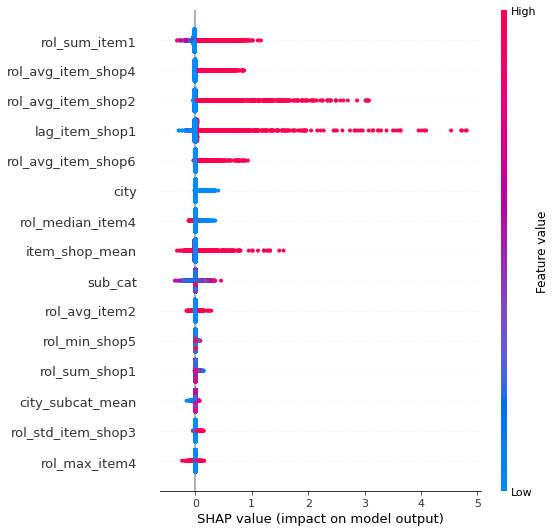

Томск


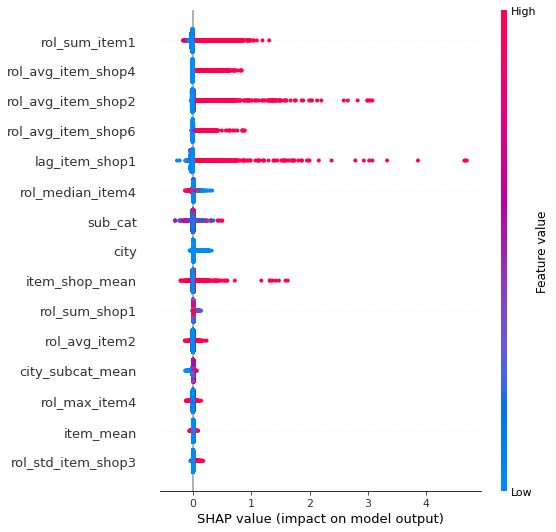

Тюмень


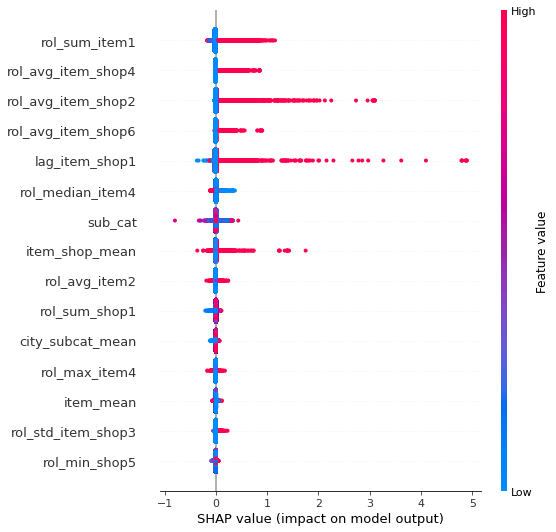

Уфа


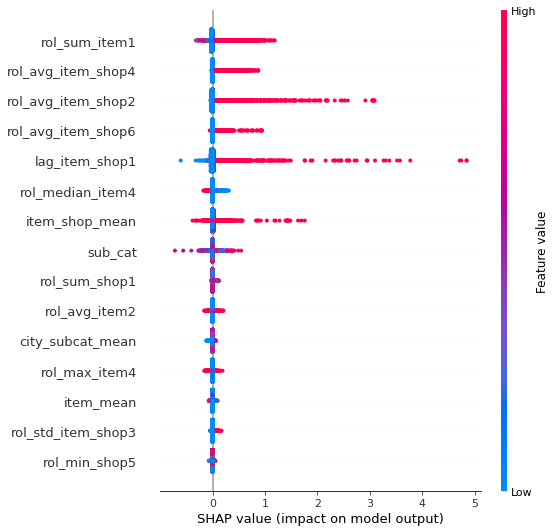

Химки


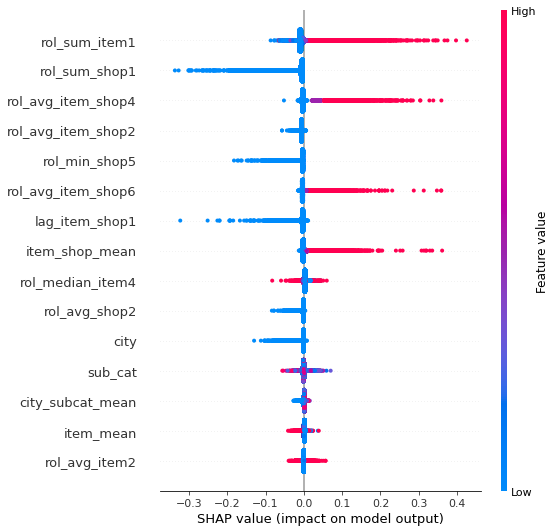

Цифровой


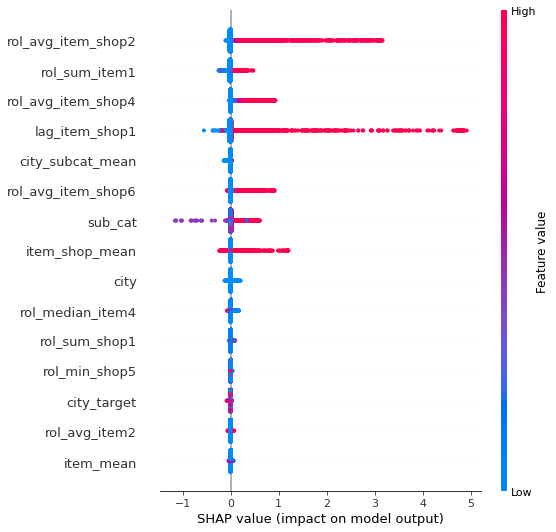

Чехов


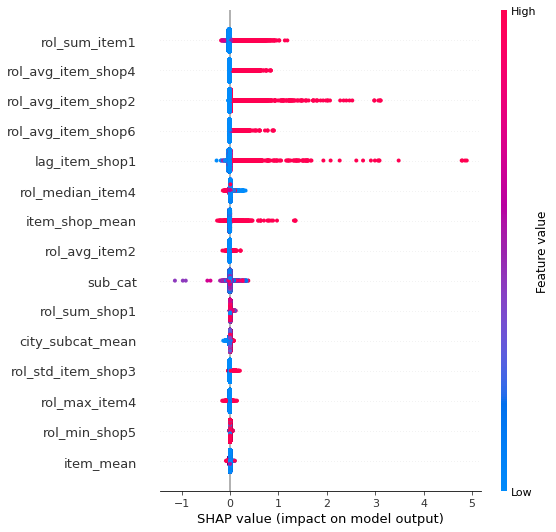

Якутск


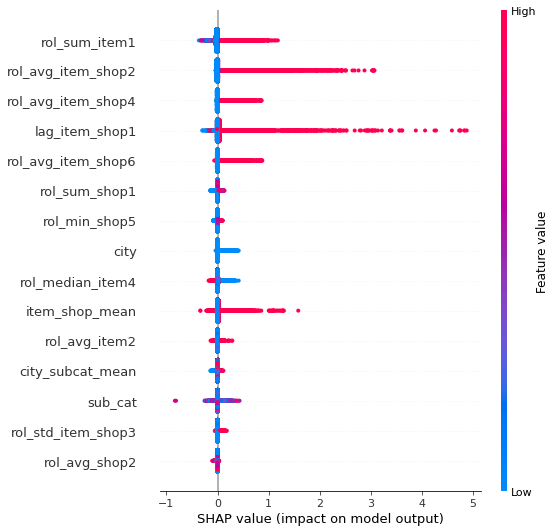

Ярославль


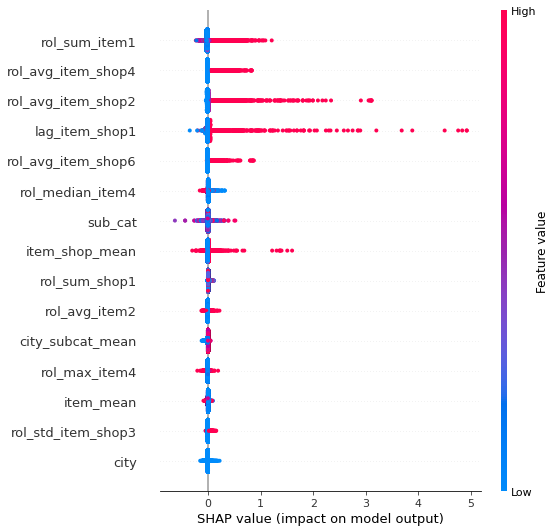

In [ ]:
for i in range(len(cities)):
    mask = X[:,1] == i
    print(decoder._decode('city',i))
    shap.summary_plot(shap_values[mask], X[mask], feature_names=num_cols, max_display=15)

1С:Предприятие 8


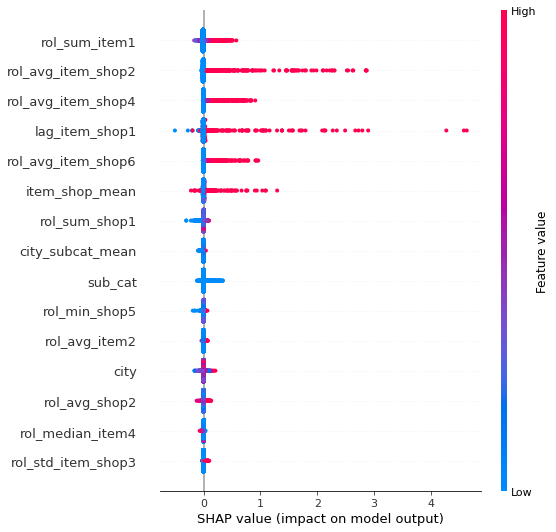

Blu-Ray


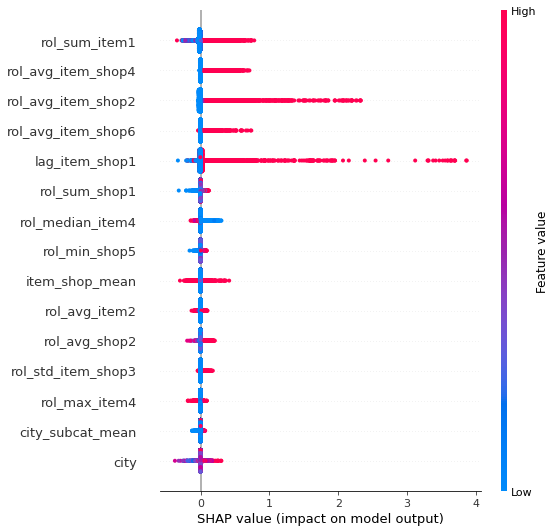

Blu-Ray 3D


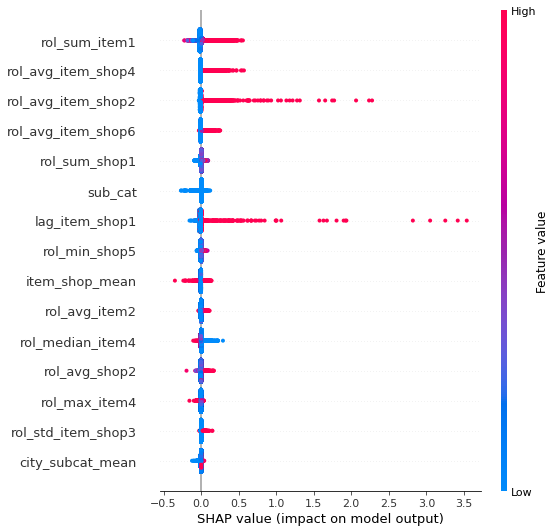

Blu-Ray 4K


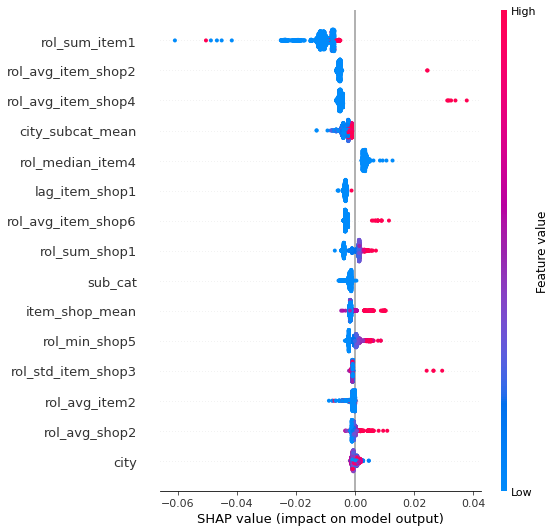

CD локального производства


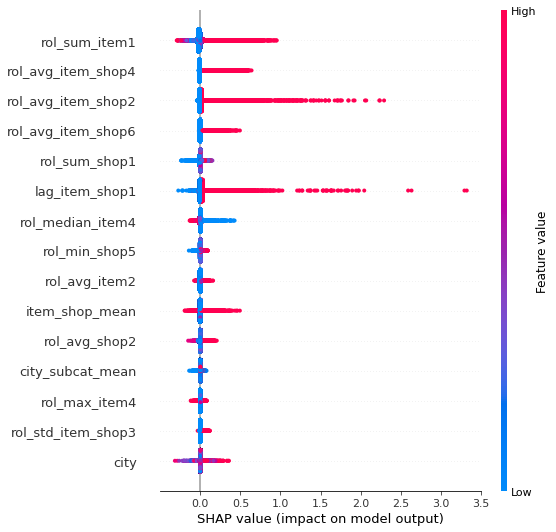

CD фирменного производства


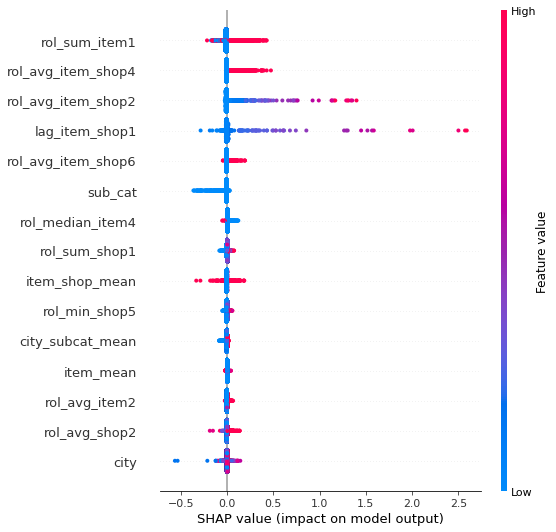

DVD


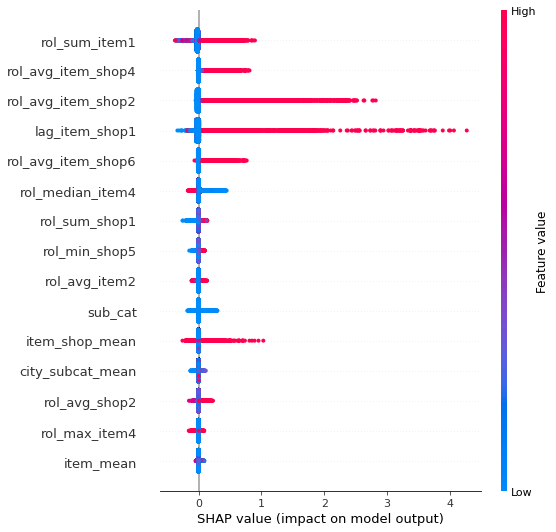

Live!


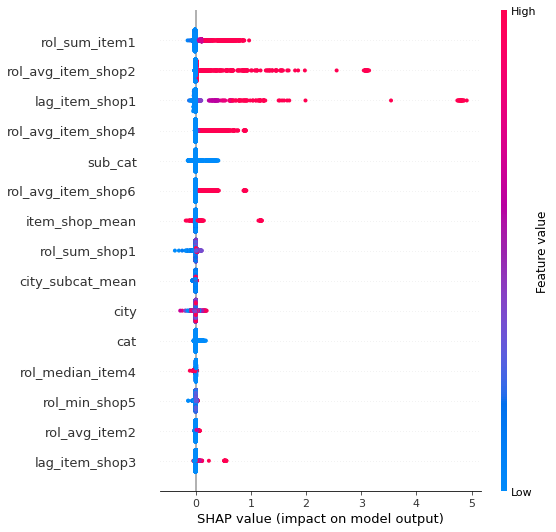

MAC


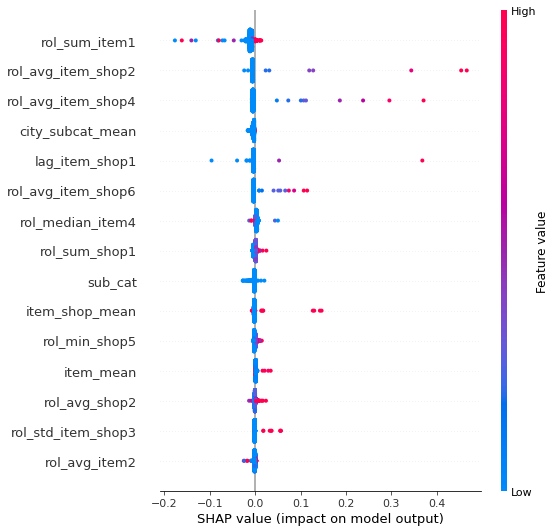

MP3


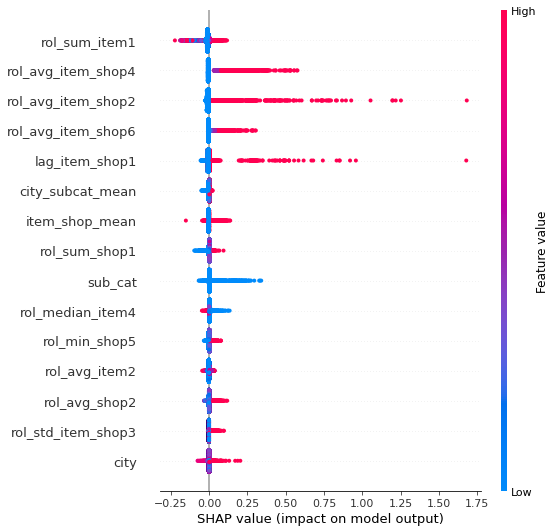

PS2


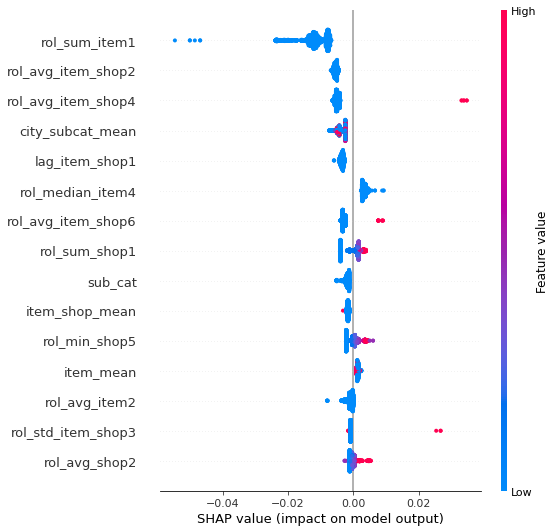

PS3


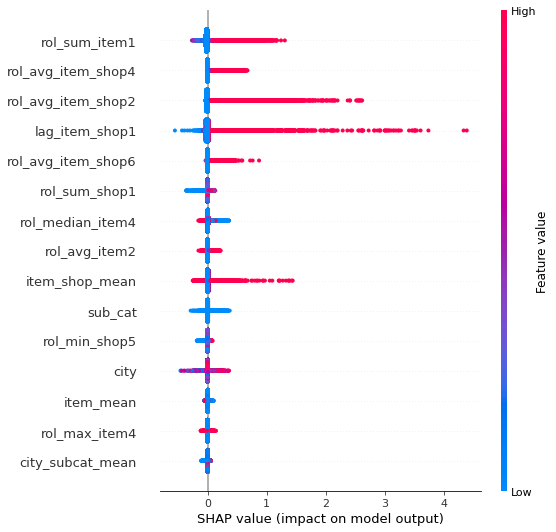

PS4


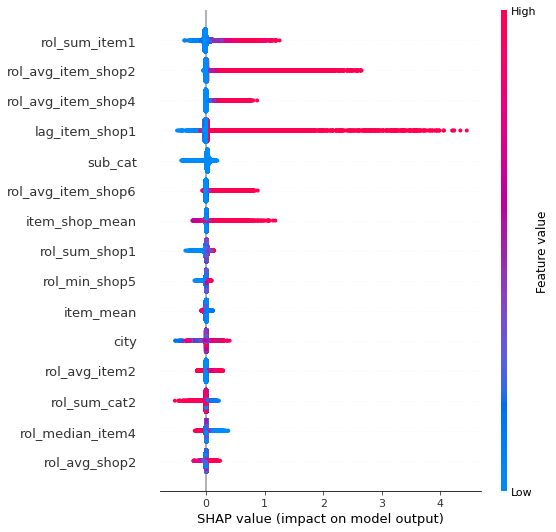

PSN


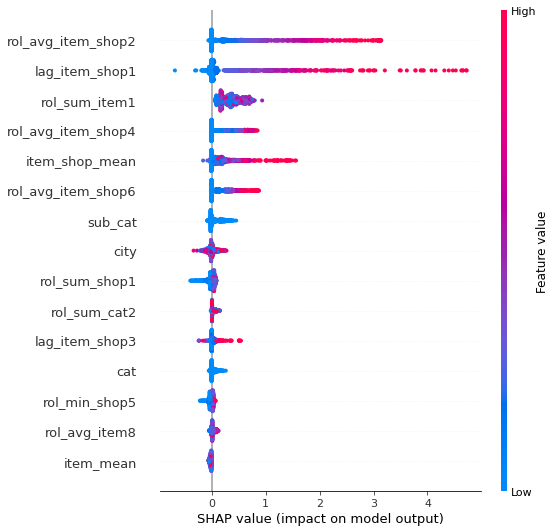

PSP


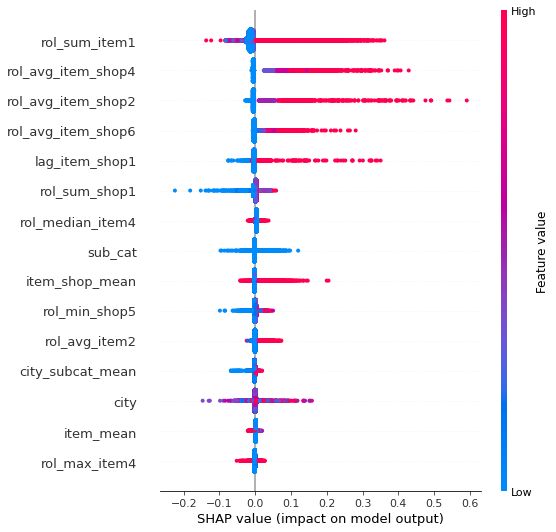

PSVita


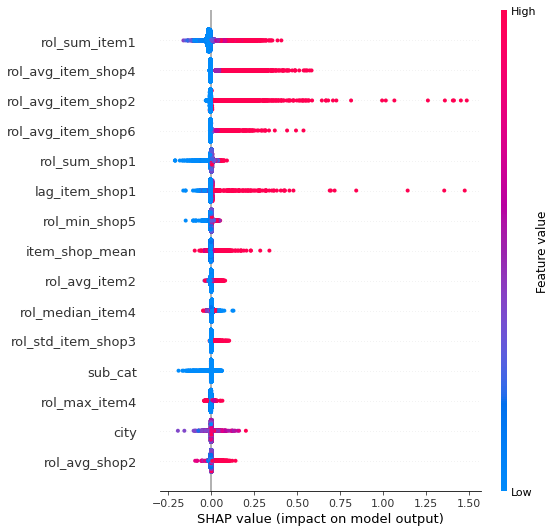

Windows


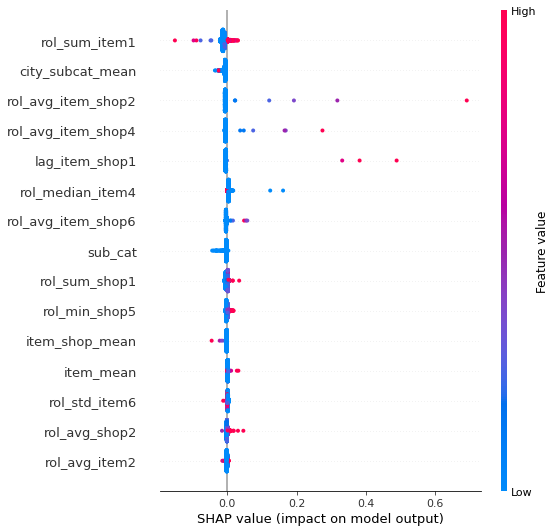

XBOX 360


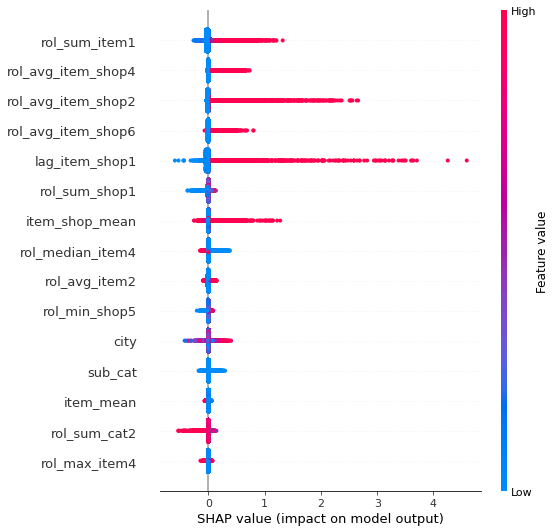

XBOX ONE


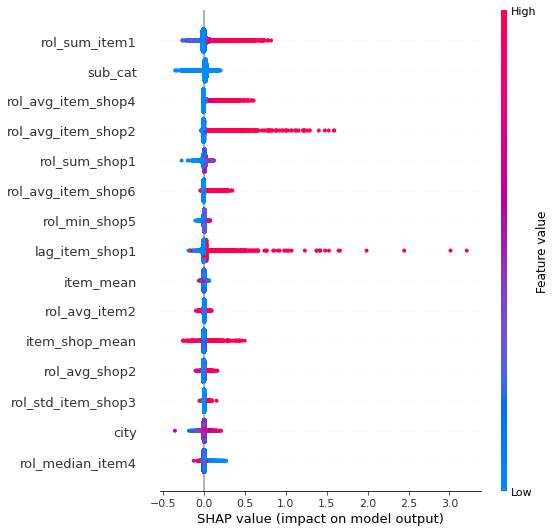

Аксессуары для игр


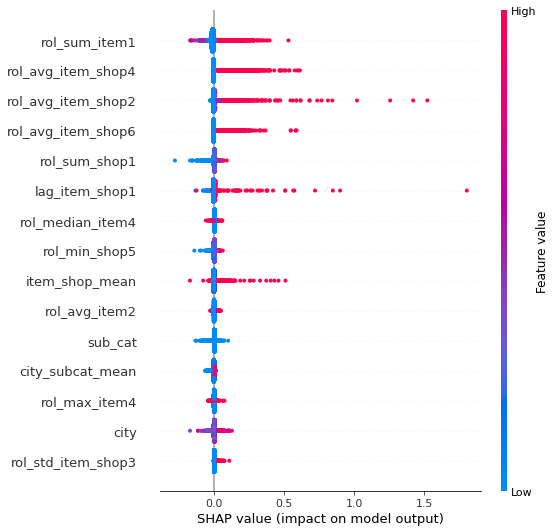

Артбуки, энциклопедии


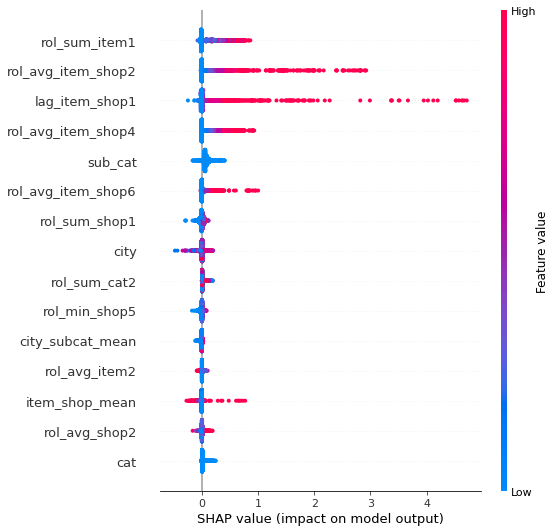

Атрибутика


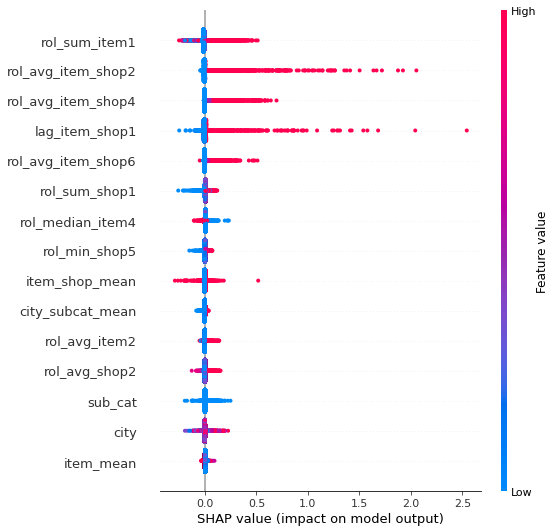

Аудиокниги


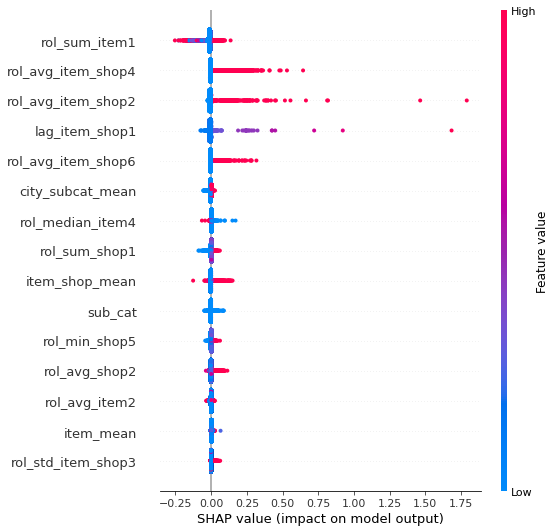

Аудиокниги 1С


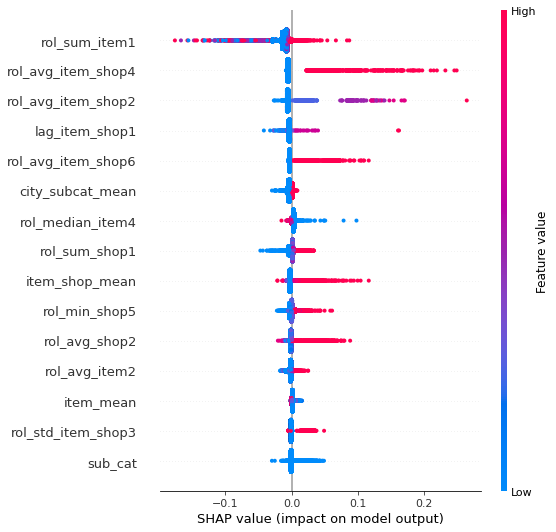

Бизнес литература


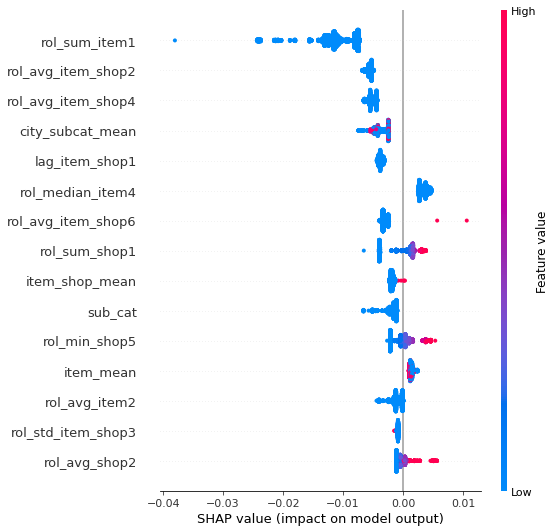

Билеты


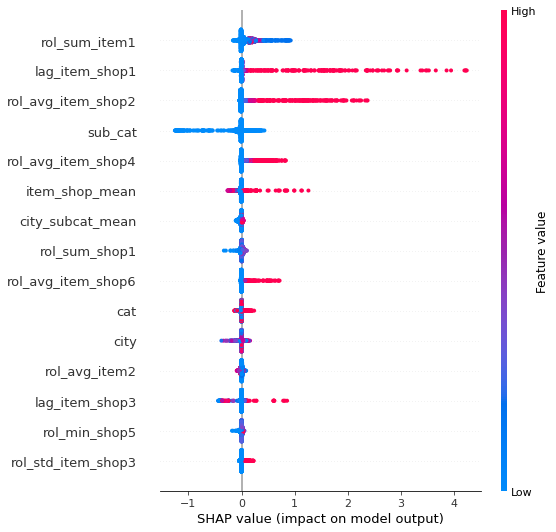

Винил


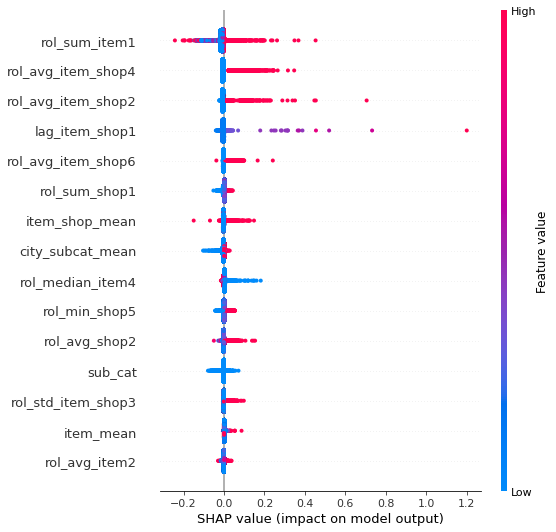

Гаджеты, роботы, спорт


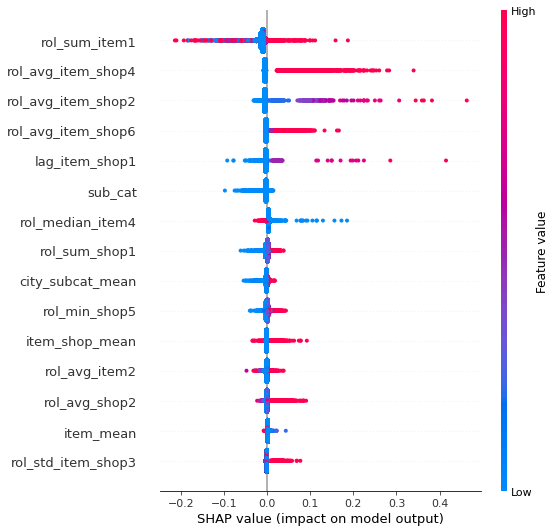

Гарнитуры/Наушники


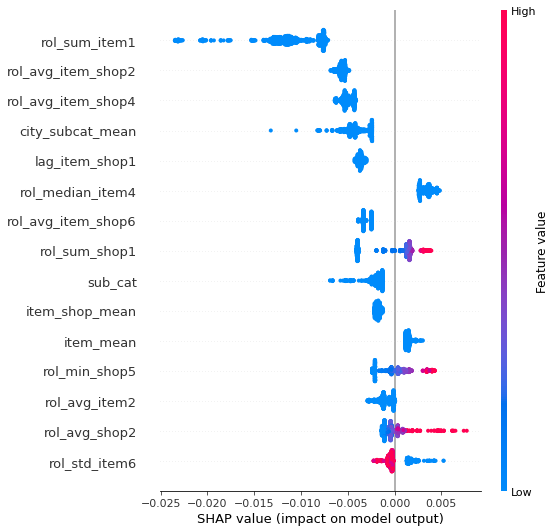

Для дома и офиса


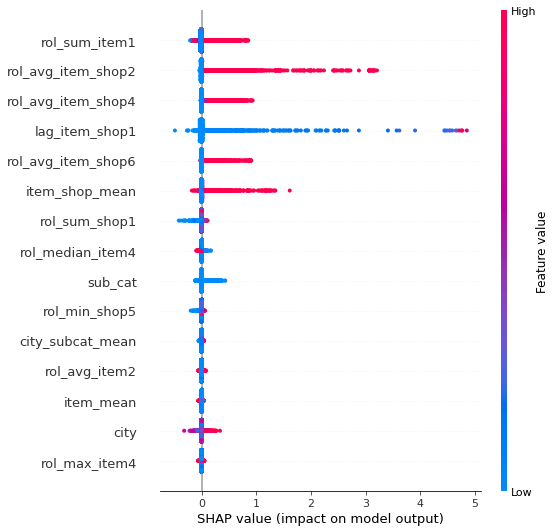

Дополнительные издания


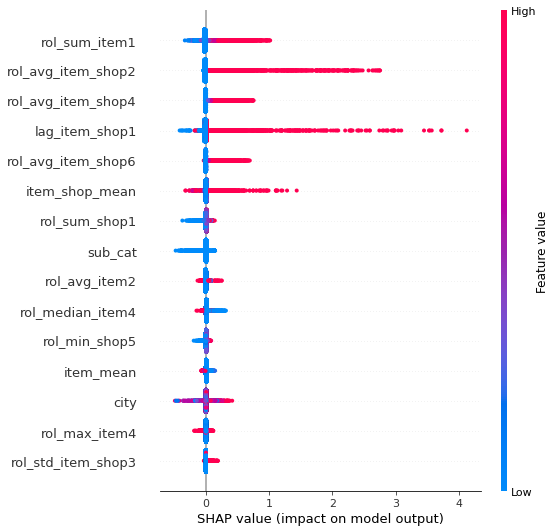

Доставка товара


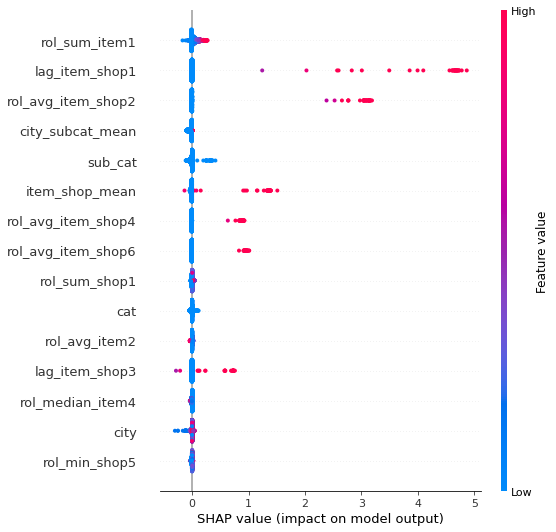

Карты оплаты


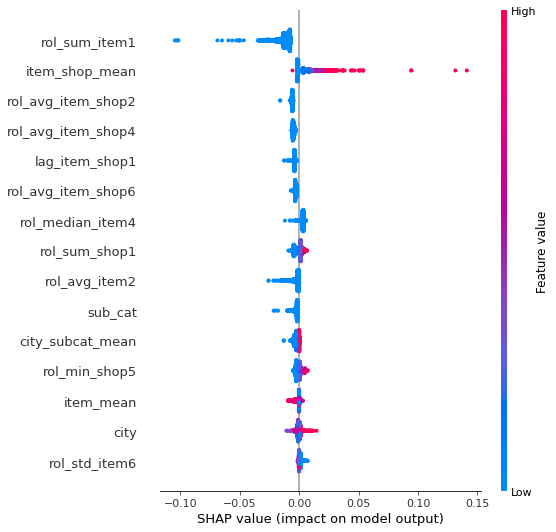

Коллекционное


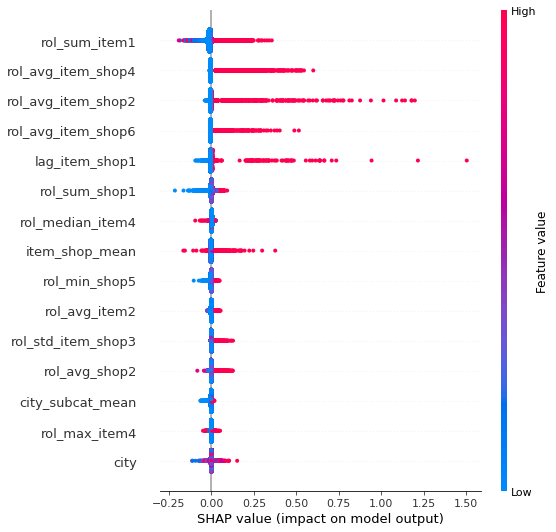

Коллекционные издания


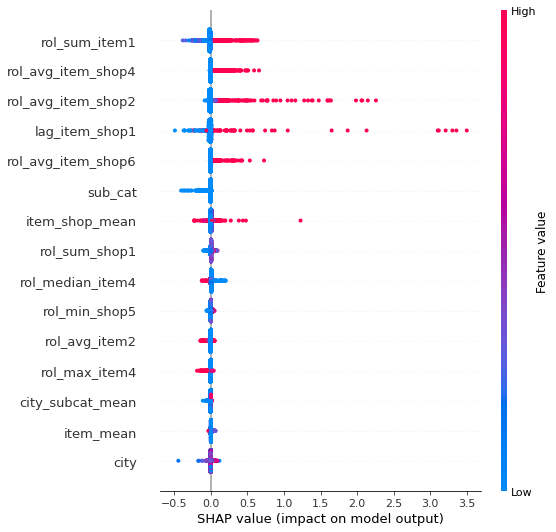

Комиксы, манга


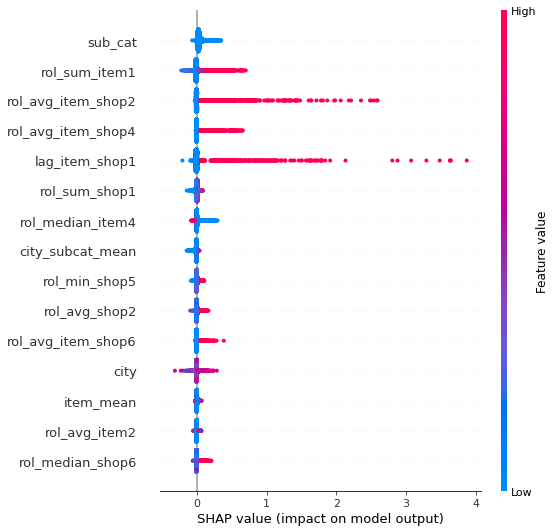

Компьютерная литература


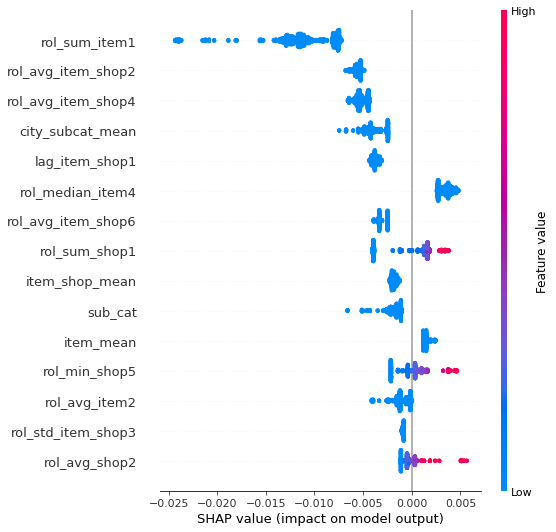

Методические материалы 1С


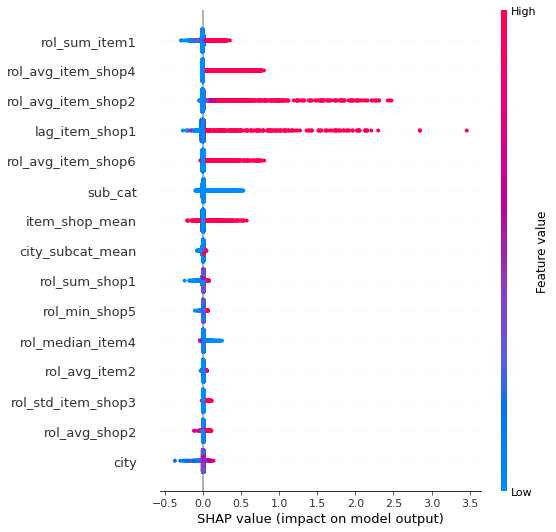

Музыкальное видео


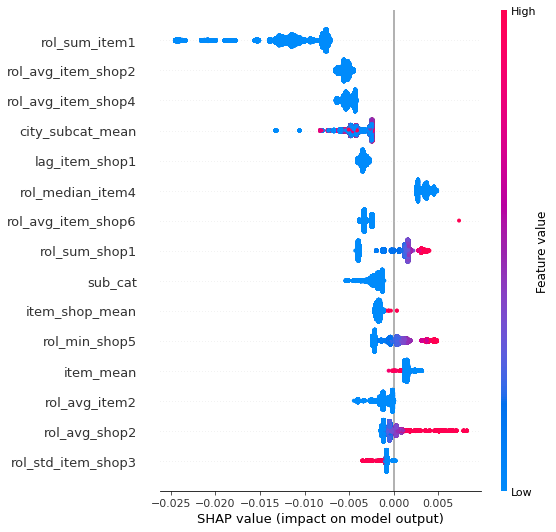

Мягкие игрушки


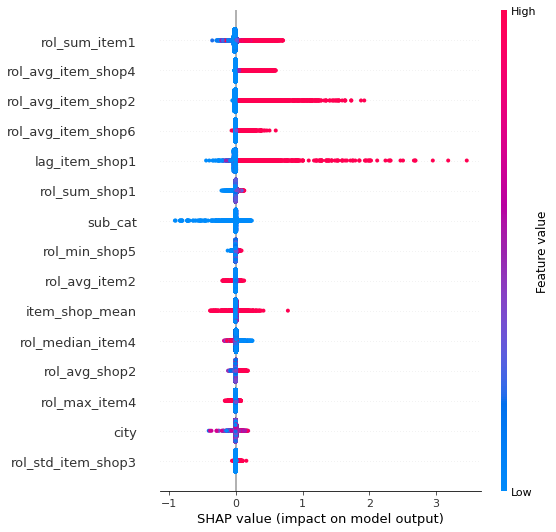

Настольные игры


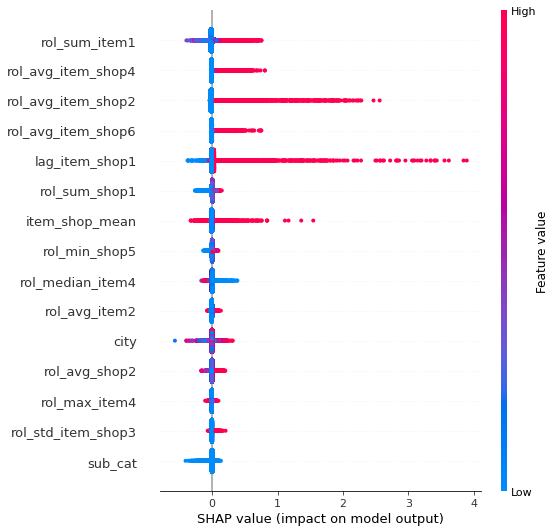

Обучающие


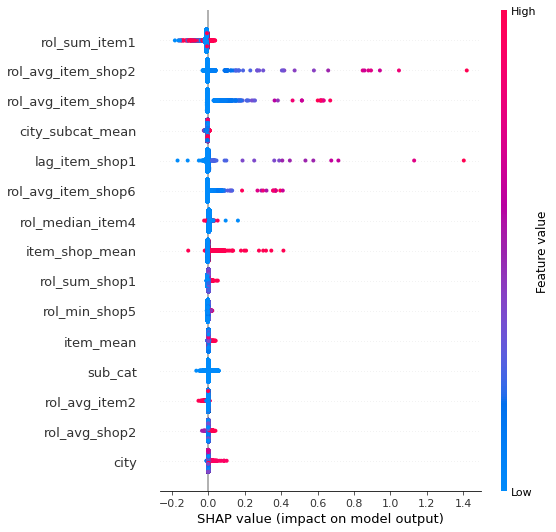

Открытки


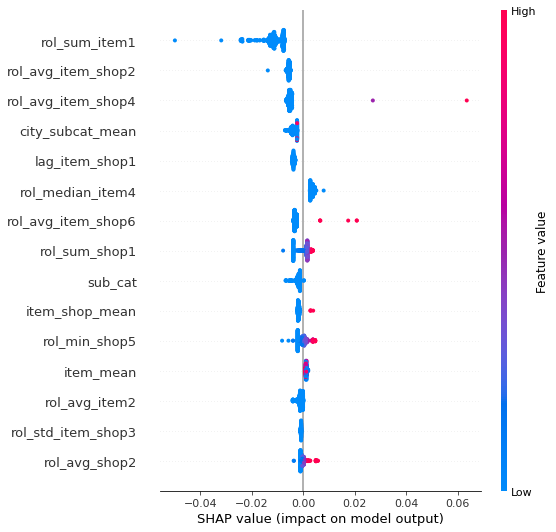

Открытки, наклейки


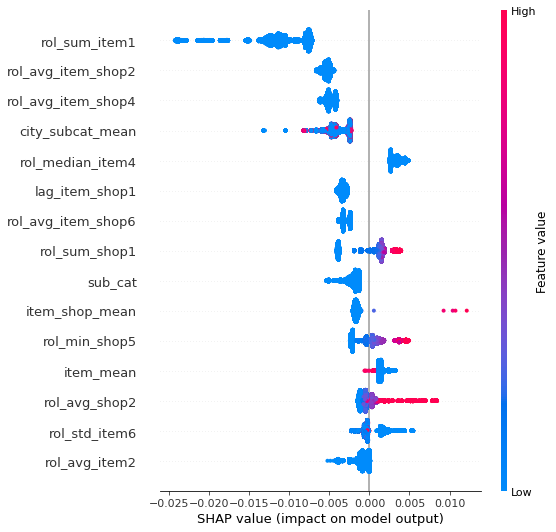

Подарочные издания


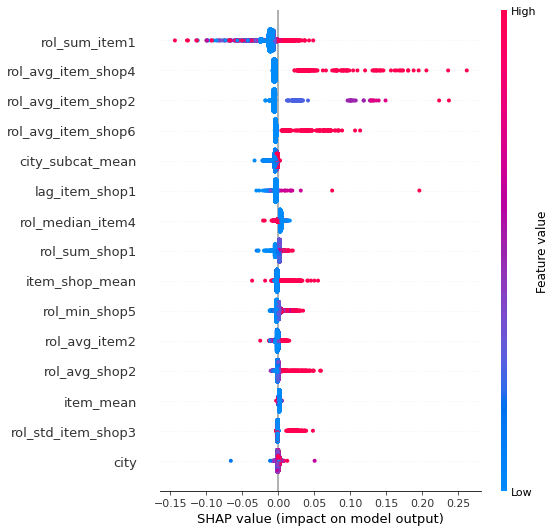

Познавательная литература


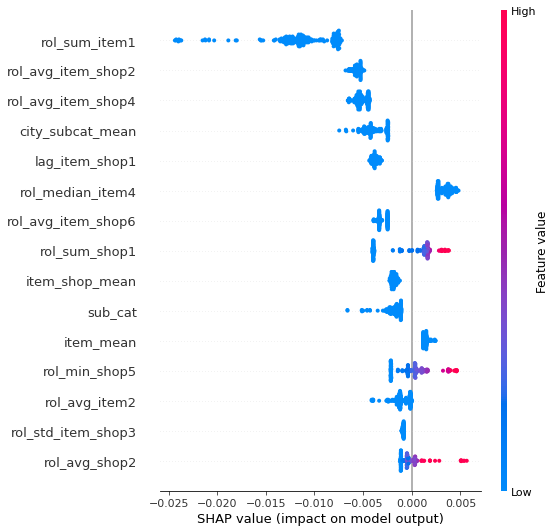

Прочие


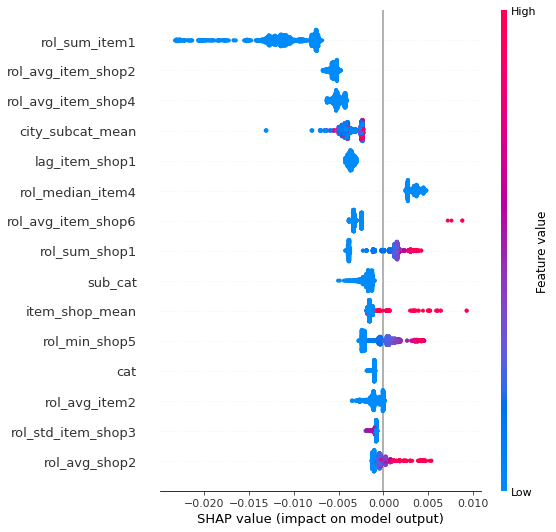

Путеводители


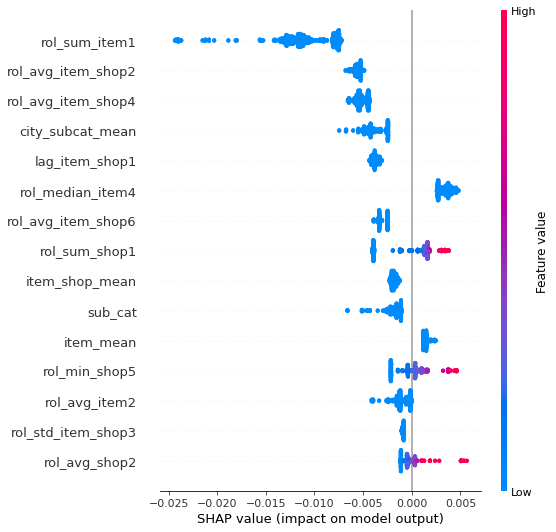

Развитие


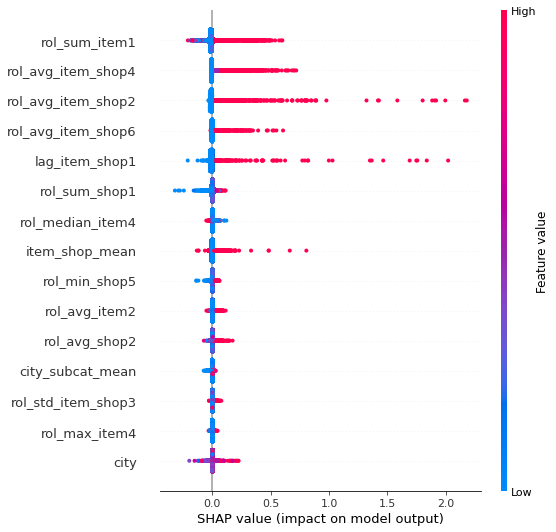

Сертификаты, услуги


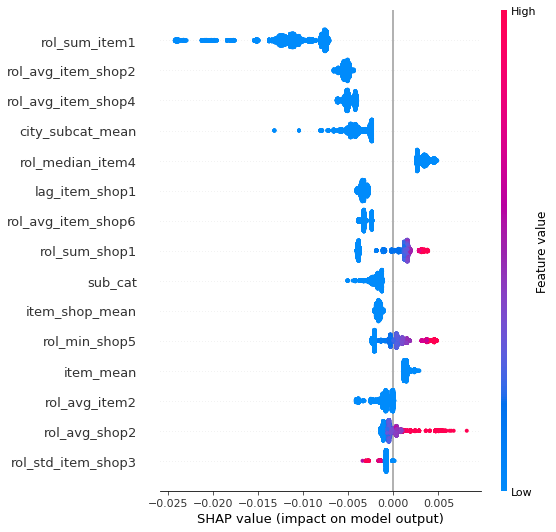

Служебные


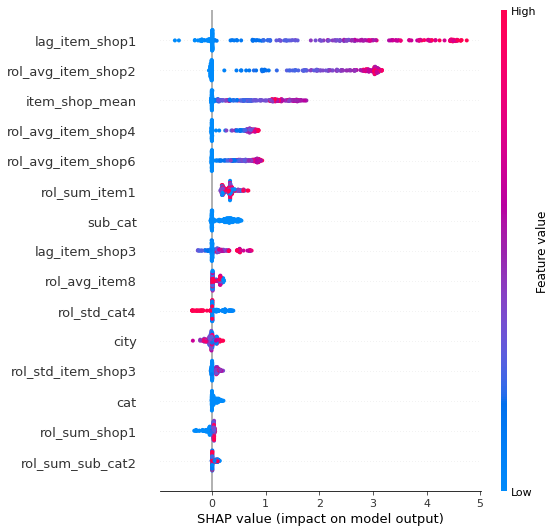

Стандартные издания


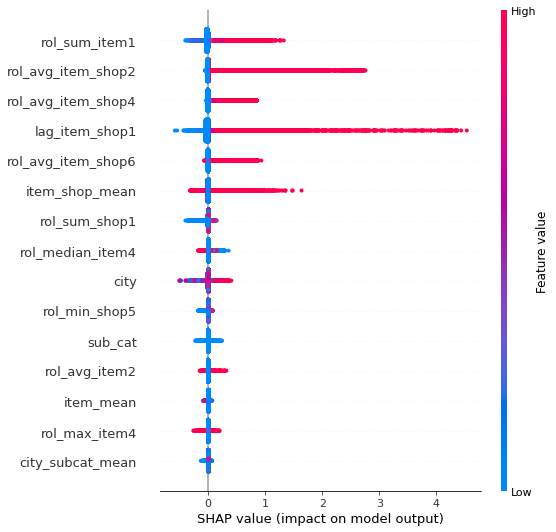

Сувениры


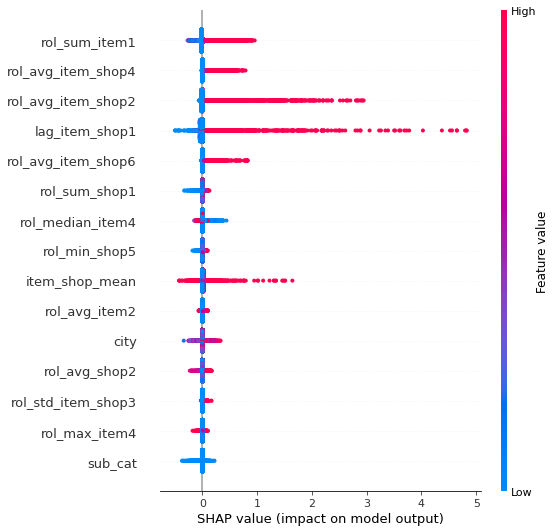

Сумки, Альбомы, Коврики д/мыши


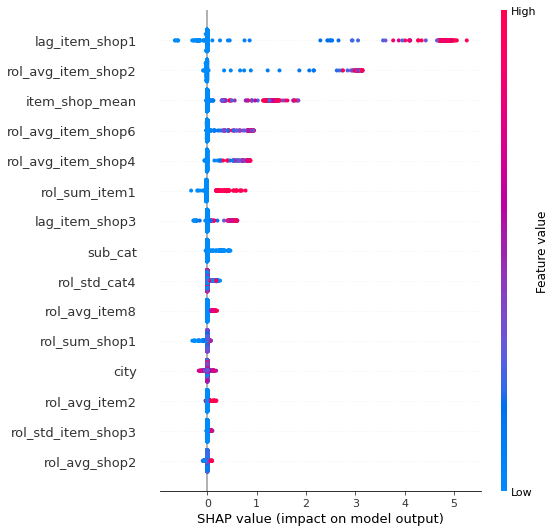

Фигурки


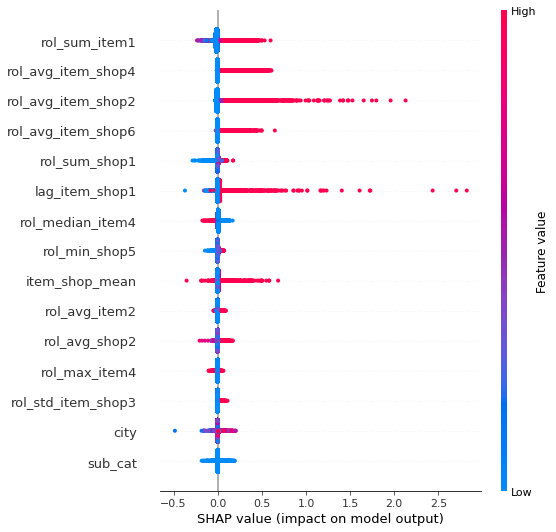

Художественная литература


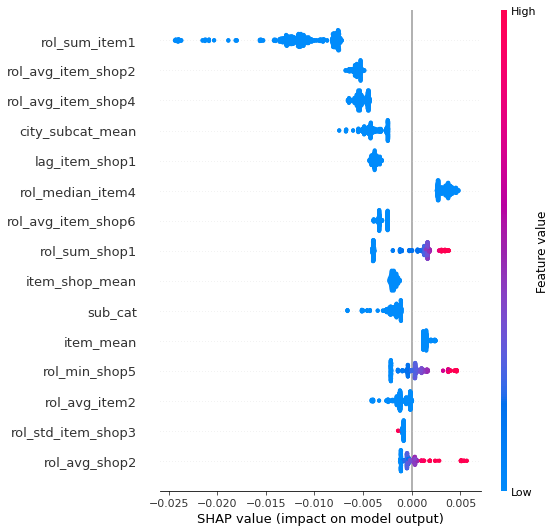

Цифра


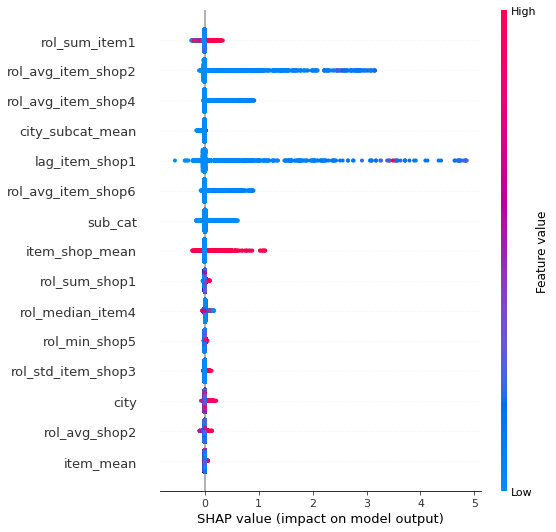

Чистые носители


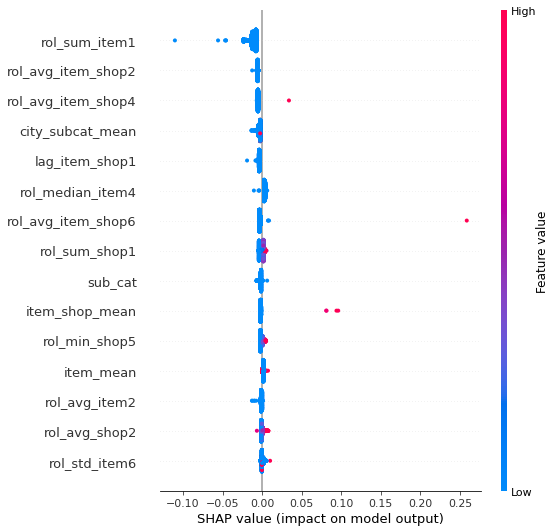

Элементы питания


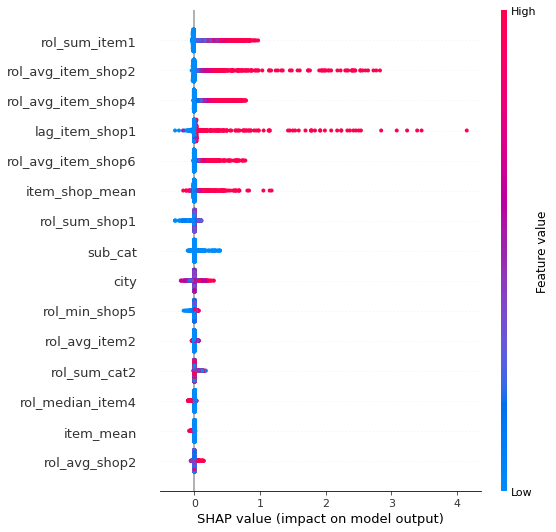

In [ ]:
for i in range(len(sub_cats)):
    mask = X[:,3] == i
    print(decoder._decode('sub_cat',i))
    shap.summary_plot(shap_values[mask], X[mask], feature_names=num_cols, max_display=15)

# Learning curves

In [ ]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, X, y, axes=None, ylim=None,cv=None,train_sizes=np.linspace(0.1, 1.0, 5)):
   

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y,
        scoring='neg_mean_absolute_error',
        cv=cv, train_sizes=train_sizes, return_times=True,
    )
    train_scores_mean = np.mean(-train_scores, axis=1)
    test_scores_mean = np.mean(-test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    plt.legend(loc="best")

    return plt

In [ ]:
cv = TimeSeriesSplitter(X,months, 0, min_train_size=train_size).split()
plot_learning_curve(model, X, y, cv=cv)

# Feature selection

## Boruta

In [ ]:
trans = BorutaPy(model, verbose=2, n_estimators=90, max_iter=50,)
sel = trans.fit(X, y)

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	38
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 50
Confirmed: 	38
Tentative: 	0
Rejected: 	0


## SHAP

In [ ]:
explainer = TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [ ]:
explainer1 = TreeExplainer(model)
shap_values1 = explainer1(X)

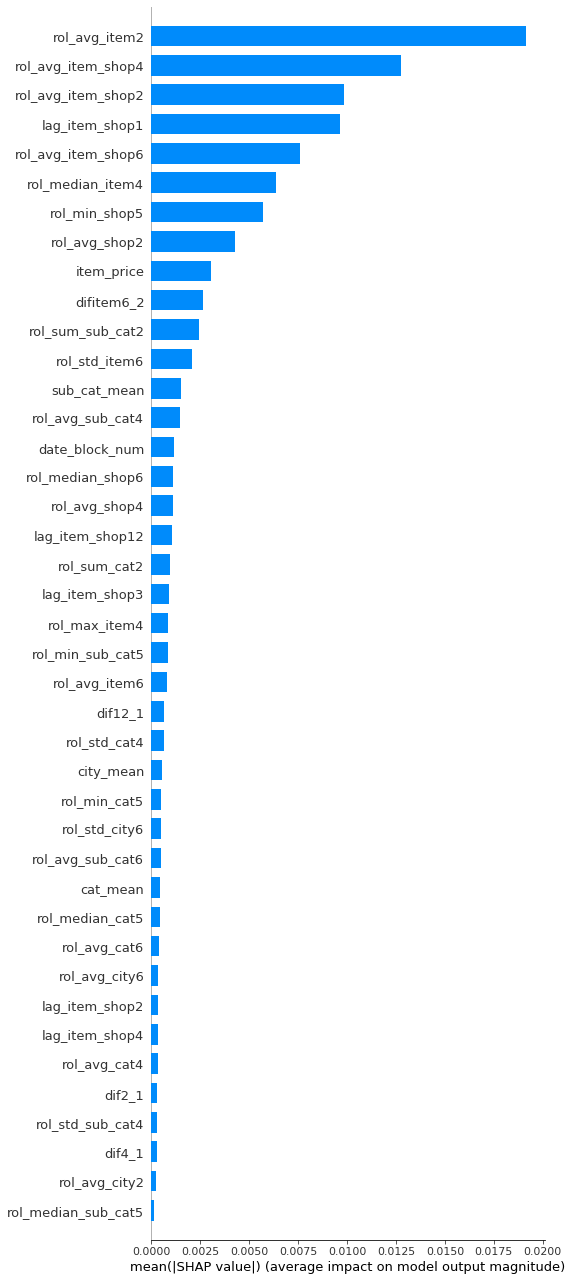

In [ ]:
shap.summary_plot(b, X, feature_names=num_cols, plot_type="bar", max_display=50)